<p align="center">
<img style="width:90%;" src="https://cdn.pixabay
.com/photo/2016/04/30/08/35/aircraft-1362586_960_720.jpg">
</p>

[Image source](https://pixabay.com/photos/aircraft-sunset-silhouette-clouds-1362586/)


<h1 style="text-align: center; color:#01872A; font-size: 80px;
background:#daf2e1; border-radius: 20px;
">Airline passengers with LSTM. </h1>

## Please use nbviewer to read this notebook to use all it's features:

https://nbviewer.org/github/sersonSerson/Projects/blob/master/TimeSeries/SarimaxAirlinePassengers/SarimaxAirlinePassengers.ipynb


# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Contents </span>


## 1.	[EDA](#step1)
## 2.	[Test harness](#step2)
## 3.	[Choosing SARIMA parameters](#step3)
## 4.	[SARIMA](#step4)
## 5.	[SARIMA grid search](#step5)
## 6.	[Check residuals](#step6)
## 7.	[Test scoring](#step7)
## 8.   [Summary](step8#)


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import random

import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ParameterGrid

from tqdm import tqdm_notebook

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional, \
    BatchNormalization
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error

warnings.filterwarnings(action='ignore')
pd.options.display.max_rows = None

In [2]:
# Configure Matplotlib and seaborn
plt.style.use('seaborn-muted')
sns.set_palette('muted')
plt.rcParams['figure.figsize'] = (16,5);
plt.rcParams['figure.facecolor'] = '#daf2e1'
plt.rcParams['axes.facecolor'] = '#daf2e1'
plt.rcParams['axes.grid'] = True
plt.rcParams['lines.linewidth'] = 5
plt.rcParams['figure.titlesize'] = 30
plt.rcParams['axes.titlesize'] = 25
plt.rcParams['image.cmap']=cm.tab10
plt.rcParams['font.family'] = 'serif'
plt.rcParams['xtick.labelsize']=14
plt.rcParams['ytick.labelsize']=14
cmap = cm.tab10
blue = cmap.colors[0]
orange = cmap.colors[1]
green = cmap.colors[2]

In [3]:
series = pd.read_csv('data/international-airline-passengers.csv',
                     index_col=0, parse_dates=True,
                     squeeze=True, names=['Month', 'Passengers'],
                     header=0,
                     )
series = series[:-1].astype('int')
series.index = pd.to_datetime(series.index)

# Create a pivot table for data
df = pd.DataFrame()
df['Month'] = series.index.month
df['Year'] = series.index.year
df['Date'] = series.index
df['Passengers'] = series.values
df_pivot = pd.pivot_table(df, values='Passengers', columns='Year',
                          index='Month')

<div id="step1">
</div>

<h2 style="padding: 10px;
 background:#daf2e1;
  border-radius: 20px;
 text-align: center; color:#01872A;
 font-size: 40px;">
Step 1. EDA.</h2>

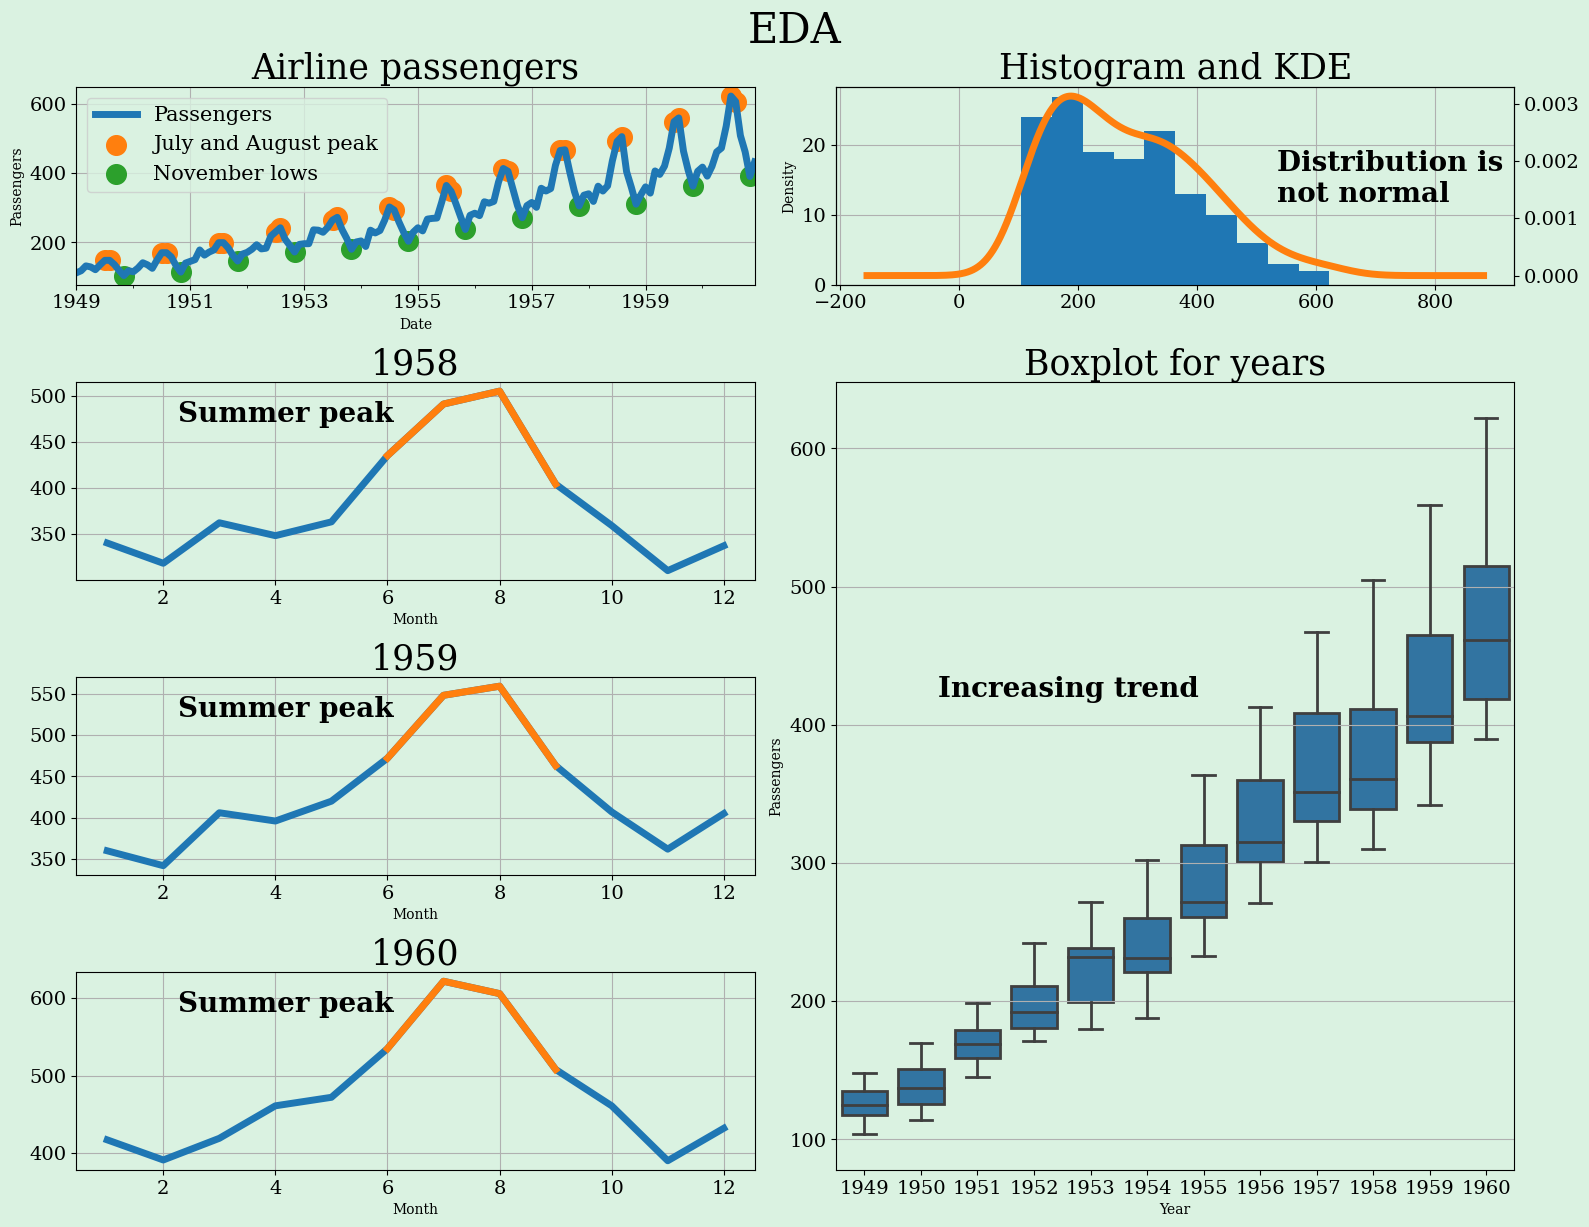

In [4]:
fig = plt.figure(figsize=(16, 15))
layout = (5, 2)
line_ax = plt.subplot2grid(layout, (0, 0))
hist_ax = plt.subplot2grid(layout, (0, 1))
series.plot(ax=line_ax, label='Passengers', color=blue)
df[df['Month'].isin([7, 8])].plot(x='Date', y='Passengers', kind='scatter',
                                  ax=line_ax, color=orange, s=200,
                                  label='July and August peak', zorder=2)
df[df['Month'].isin([11])].plot(x='Date', y='Passengers', kind='scatter',
                                  ax=line_ax, color=green, s=200,
                                  label='November lows', zorder=2)
line_ax.set_title('Airline passengers')
line_ax.legend(fontsize=15)
series.plot(kind='hist', ax=hist_ax, zorder=10, color=blue)
series.plot(kind='kde', ax=hist_ax, secondary_y=True, color=orange)
hist_ax.text(0.65, 0.42, 'Distribution is\nnot normal',
             transform = hist_ax.transAxes, size=20, fontweight='bold')
hist_ax.right_ax.grid(False)
hist_ax.grid(True, zorder=0)
hist_ax.set_title('Histogram and KDE');

axes = [plt.subplot2grid(layout, (1, 0)), plt.subplot2grid(layout, (2, 0)),
        plt.subplot2grid(layout, (3, 0))]

years = ['1958', '1959', '1960']
df_pivot.loc[:, years[0]:years[-1]].plot(kind='line', subplots=True,
                                    grid=True, color=blue,
                                    legend=False,
                                    title=years,
                                    ax=axes)
df_pivot.loc[6:9, years[0]:years[-1]].plot(kind='line', subplots=True,
                                      grid=True,  color=orange,
                                      ax=axes, legend=False,
                                      title=years)
for i in range(len(years)):
    axes[i].text(0.15, 0.8, 'Summer peak', transform=axes[i].transAxes,
                    size=20, fontweight='bold')
# Boxplot
boxplot_ax = plt.subplot2grid(layout, (1, 1), rowspan=3)
sns.boxplot(x='Year', y='Passengers', linewidth=2, data=df,
            color=blue, ax=boxplot_ax)
boxplot_ax.text(0.15, 0.6, 'Increasing trend', transform=boxplot_ax.transAxes,
                size=20, fontweight='bold')
boxplot_ax.set_title('Boxplot for years')
plt.suptitle('EDA')
plt.tight_layout()
plt.show();

<h2 style="padding: 10px; text-align: left; color:#01872A; font-size: 30px;
font-style: italic; background:#daf2e1; border-radius: 20px;
">Step 1 results:</h2>

### 1. **Increasing trend** over years.
### 2. **Seasonality** - with peak at summer (July and August) and very low periods - November (February).

<div id="step2">
</div>

<h2 style="padding: 10px; text-align: center; color:#01872A; font-size: 40px;
background:#daf2e1; border-radius: 20px;">
Step 2. Test harness: Train-test split, scoring function, baseline.</h2>


<h3 style="padding: 10px; text-align: left; color:#01872A; font-size: 20px;
">Will use RMSE as a metric to punish for highly inaccurate predictions.</h3>
$
\ \huge RMSE = \sqrt{\frac{1}{n}\sum\limits_{i=1}^{n} (y_i - \hat{y}_i)^2}
$

## Loss function and metric

In [5]:
def score_model(y_test, predictions):
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    rmse = rmse.round(3)
    return rmse

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred)))

## Function to split data into train and test sets

In [6]:
def manual_split(series, train_size=0.6, validation_size=0.2):
    train_size = int(len(series) * train_size)
    validation_size = int(len(series) * validation_size)
    train = series.iloc[:train_size]
    validation = series.iloc[train_size:(train_size + validation_size)]
    test = series.iloc[(train_size + validation_size):]
    return train, validation, test

## Function to visualize splits

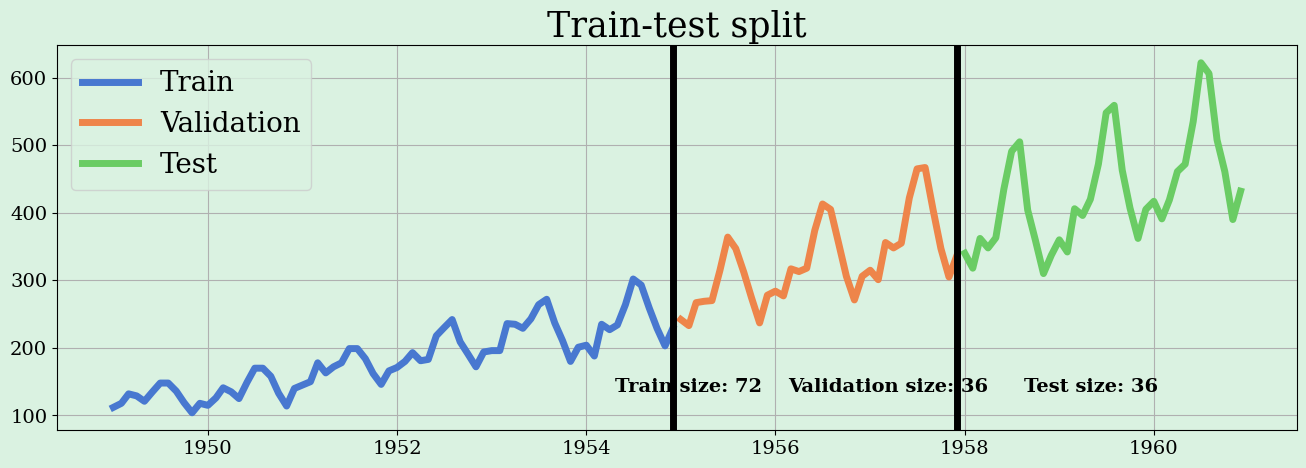

In [7]:
def plot_split(train, validation, test):
    fig, ax = plt.subplots(figsize=(16, 5))
    ax.plot(train, label='Train')
    ax.plot(validation, label='Validation')
    ax.plot(test, label='Test')
    ax.axvline(max(train.index), color='black')
    ax.axvline(max(validation.index), color='black')
    ax.set_title('Train-test split');

    ax.text(0.45, 0.1, f'Train size: {len(train)}',
            transform = ax.transAxes, size=14, fontweight='bold')
    ax.text(0.59, 0.1, f'Validation size: {len(validation)}',
            transform = ax.transAxes, size=14, fontweight='bold')
    ax.text(0.78, 0.1, f'Test size: {len(test)}',
        transform = ax.transAxes, size=14, fontweight='bold')
    ax.legend(prop={'size': 20})
    plt.show();
train, validation, test = manual_split(series, train_size=0.5,
                                       validation_size=0.25)
dataset = pd.concat([train, validation])
plot_split(train, validation, test)

## Function to visualize splits

In [ ]:
scaler = MinMaxScaler()
series_sc = scaler.fit_transform(series.values.reshape(-1 ,1))
train_sc = scaler.transform(train.values.reshape(-1 ,1))
validation_sc = scaler.transform(validation.values.reshape(-1 ,1))
test_sc = scaler.transform(test.values.reshape(-1 ,1))

## Function to visualize predictions

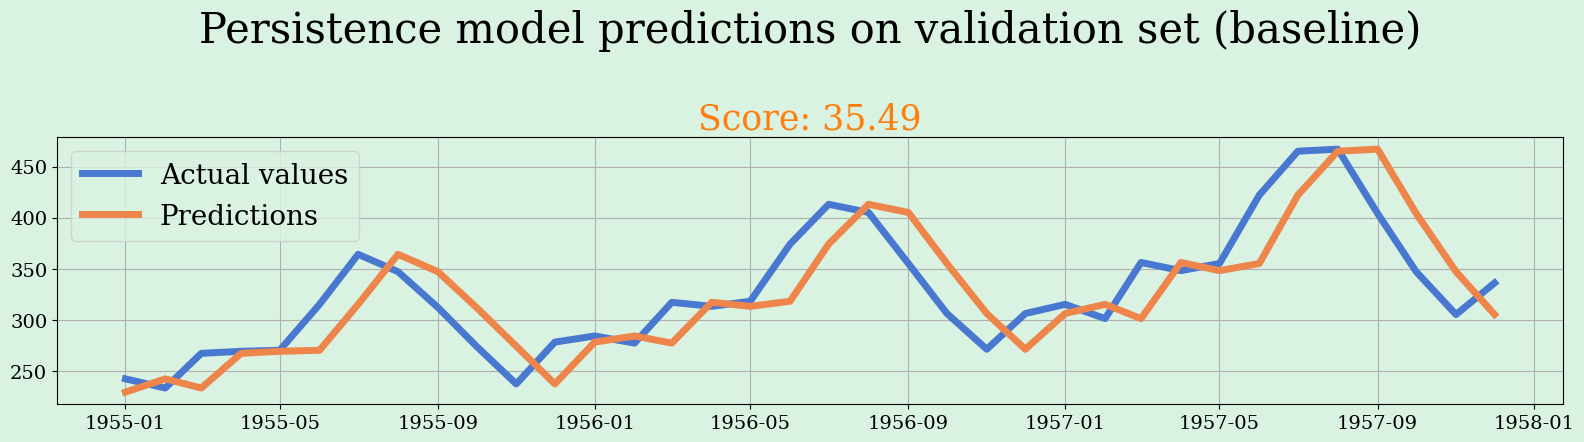

In [11]:
def plot_predictions(values, predictions, title='', score=0, ax=None,
                     train_test_point=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(values, label='Actual values')
    ax.plot(predictions, label='Predictions')
    ax.text(0.5, 1.4, f'{title}', ha="center", va="center",
            transform = ax.transAxes, size=30)
    ax.set_title(f'Score: {score}', color=orange)
    ax.legend(prop={'size': 20})
    if train_test_point:
        ax.axvline(train_test_point, color='black')
    plt.tight_layout()
    plt.show();

## Use mean of the training set for baseline
$
\ \huge value_{(t)} = mean_{(train)}
$

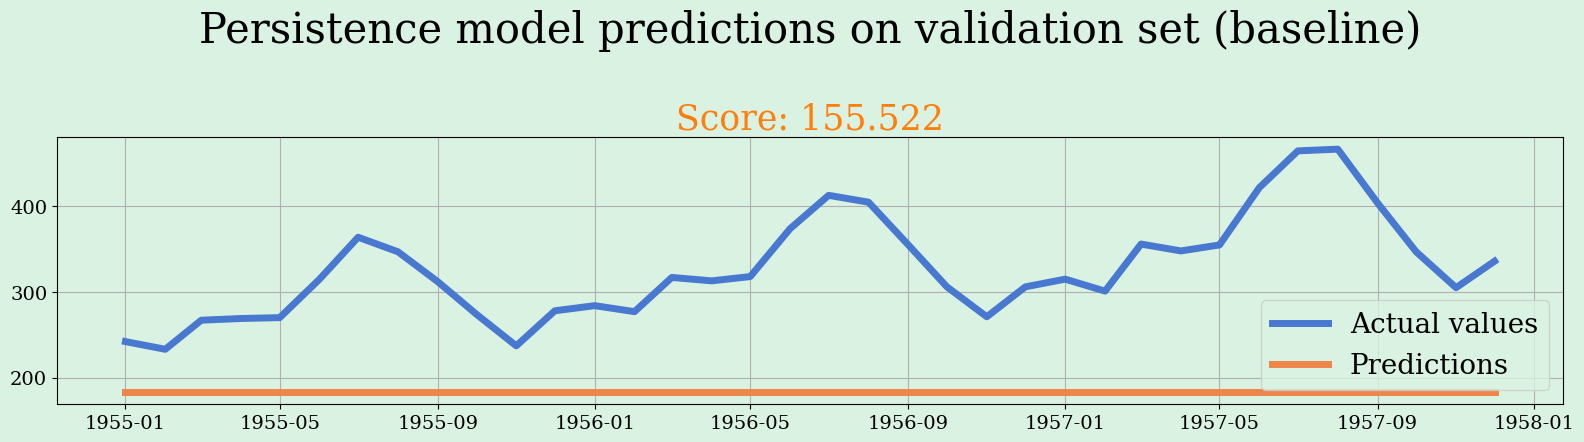

In [90]:
baseline_val_preds = pd.Series(train.mean(), index=validation.index)
baseline_val_score = score_model(validation, baseline_val_preds)
plot_predictions(validation, baseline_val_preds,
                 title='Persistence model predictions on validation set '
                       '(baseline)', score=baseline_val_score)

<h3 style="padding: 10px; text-align: left; color:#01872A; font-size: 20px;
">Prepare data.</h3>

Function creates train and test datasets to score models with. Steps:
1. Scale data.
2. Create datasets with n timesteps of training data and one timestep of test
 data with rolling window method.
3. Returns train and test datasets and the scaler object to scale the
predictions back.


In [13]:
def create_data(series, train, test, timesteps):
    # Train data
    X_train = []
    y_train = []
    for i in range(int(timesteps), len(train)):
        X_train.append(train[i - timesteps:i])
        y_train.append(train[i])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    # Test data
    test_data = \
        series[len(train) - timesteps:len(train) + len(test)]

    test_data = test_data.reshape(-1, 1)
    X_test = []
    for i in range(timesteps, len(test_data)):
        X_test.append(test_data[i - timesteps:i])
    X_test = np.array(X_test)
    y_test = test.reshape(-1, 1).copy()

    return X_train, y_train, X_test, y_test

<h2 style="padding: 10px; text-align: left; color:#01872A; font-size: 30px;
background:#daf2e1; border-radius: 20px;
">Step 2 results:</h2>

### 1. **Split data** into the train, validation and test sets.
### 2. **Established a baseline** to check future predictions against. Baseline validation score: 38.477.
### 3. **RMSE** will be used as a scoring metric.
### 4. Created a function that generates train and test datasets in appropriate for keras arrays.

<div id="step3">
</div>

<h2 style="padding: 10px; text-align: center; color:#01872A; font-size: 40px;
background:#daf2e1; border-radius: 20px;">
Step 3. Choosing model topology</h2>

## Define functions for model evaluation

In [14]:
def learning_curve(history, model_name=None):
    metrics = history.model.metrics_names
    n_metrics = len(metrics)
    fig, axes = plt.subplots(1, n_metrics, figsize=(18, 4))
    if n_metrics == 1:
        axes = [axes]
    for ax, metric in zip(axes, metrics):
        metric_value = history.history[metric]
        ax.plot(metric_value, label=f'Train {metric}')
        val_metric = 'val_' + metric
        if val_metric in history.history:
            val_metric_value = history.history[val_metric]
            ax.plot(val_metric_value, label=f'Test {metric}')
        ax.set_title(metric.capitalize(), size=14)
        ax.legend()
    if model_name:
        fig.text(0.5, 1.05, f'{model_name}', ha="center", va="center",
                 size=25)
    plt.show()

In [15]:
def score_model(y_test, predictions):
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    rmse = rmse.round(3)
    return rmse

In [16]:
def compile_fit_model(X_train, y_train, X_test, y_test, model, callbacks=[],
                      verbose=0):
    model.compile(optimizer='adam', loss=root_mean_squared_error)
    history = model.fit(X_train, y_train, epochs=700, verbose=verbose,
                        validation_data=(X_test, y_test),
                        callbacks=callbacks, batch_size=len(X_train))
    return history

## Define Early Stopping Callback

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=100)

## Need to choose:
1. Model topology - number of layers and units, simple LSTM or Bidirectional
LSTM
2. Number of timesteps to use.
3. Will use the whole training set as a batch size, as training set is quite
small.

# Create datasets with different number of months
As there is clear yearly seasonality, use multipliers of 12 for training period
size:
1. 12 months
2. 24 months
3. 36 months
4. 48 months
5. 60 months

In [18]:
timesteps = 12
X_train_12, y_train_12, X_val_12, y_val_12 = \
    create_data(series_sc, train_sc, validation_sc, timesteps=timesteps)

In [19]:
timesteps = 24
X_train_24, y_train_24, X_val_24, y_val_24 = \
    create_data(series_sc, train_sc, validation_sc, timesteps=timesteps)

In [20]:
timesteps = 36
X_train_36, y_train_36, X_val_36, y_val_36 = \
    create_data(series_sc, train_sc, validation_sc, timesteps=timesteps)

In [21]:
timesteps = 48
X_train_48, y_train_48, X_val_48, y_val_48 = \
    create_data(series_sc, train_sc, validation_sc, timesteps=timesteps)

In [22]:
timesteps = 60
X_train_60, y_train_60, X_val_60, y_val_60 = \
    create_data(series_sc, train_sc, validation_sc, timesteps=timesteps)

In [23]:
datasets = {'12 timesteps': [X_train_12, y_train_12, X_val_12, y_val_12],
            '24 timesteps': [X_train_24, y_train_24, X_val_24, y_val_24],
            '36 timesteps': [X_train_36, y_train_36, X_val_36, y_val_36],
            '48 timesteps': [X_train_48, y_train_48, X_val_48, y_val_48],
            '60 timesteps': [X_train_60, y_train_60, X_val_60, y_val_60],
            }

In [24]:
def autolabel(rects, ax, decimals=2):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        value = round(height, decimals)
        ax.annotate('{}'.format(value),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  size=18,# 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

def update_scores(score_df, model_name, score):
    model_dict = dict()
    model_dict['ModelName'] = model_name
    model_dict['Score'] = score
    if model_name not in score_df['ModelName'].values:
        score_df = score_df.append(model_dict, ignore_index=True)
    else:
        index = score_df[score_df['ModelName'] == model_name].index[0]
        score_df.at[index, 'Score'] = score
    return score_df

In [91]:
def evaluate_model(X_train, y_train, X_test, y_test, model, history=None,
                   model_name=None, plot_learning_curve=False):
    if plot_learning_curve:
        learning_curve(history, model_name)

    y_pred_test = scaler.inverse_transform(model.predict(X_test))
    y_pred_train = scaler.inverse_transform(model.predict(X_train))

    y = np.concatenate([y_train, y_test])
    y_pred = np.concatenate([y_pred_train, y_pred_test])

    score = score_model(scaler.inverse_transform(y_test), y_pred_test)
    plot_predictions(scaler.inverse_transform(y), y_pred, score=score,
                     train_test_point=X_train.shape[0], title=model_name)
    return score


In [113]:
from tensorflow.keras.models import load_model

def load_model_from_file(model_name):
    model = load_model(model_path + model_name + '.h5',
                       custom_objects={'root_mean_squared_error' :
                                           root_mean_squared_error})
    return model

def evaluate_on_multiple_sets(datasets, model, model_name, score_df,
                              plot_learning_curve=False, use_saved=False):
    for dataset_name, dataset in datasets.items():
        result_name = f'{dataset_name} {model_name}'
        if use_saved:
            model = load_model_from_file(result_name)
            history = None
        else:
            history = compile_fit_model(dataset[0], dataset[1],
                                        dataset[2], dataset[3], model,
                                        callbacks=[early_stopping])
        score = evaluate_model(dataset[0], dataset[1], dataset[2], dataset[3],
                               model, history, model_name=result_name,
                               plot_learning_curve=plot_learning_curve)
        score_df = update_scores(score_df, result_name, score)
        save_model(model, result_name)
    return score_df

In [81]:
def plot_model_results(score_df, metric=''):
    fig, ax = plt.subplots(figsize=(12, 8))
    score_df.sort_values(['Score'], inplace=True, ascending=True)
    score_df = score_df.iloc[:10]
    rects = ax.bar(x=score_df['ModelName'], height=score_df['Score'],
                   zorder=2, color=[blue, orange, green])
    autolabel(rects, ax, decimals=4)
    ax.text(0.5, 1.3, 'Scores', ha="center", va="center",
            transform = ax.transAxes, size=30)
    if metric:
        ax.text(0.5, 1.1, f'Metric: {metric}', ha="center", va="center",
            transform = ax.transAxes, size=20, color=orange)
        # ax.set_title(f'Metric: {metric}', color=orange, size=20)
    ax.set_ylim(0.0, score_df['Score'].max() * 1.4)
    ax.set_xticklabels(score_df['ModelName'], rotation=45, ha='right',
                       size=10)
    ax.tick_params(axis='both', which='major', labelsize=16)
    plt.tight_layout()
    plt.show()

In [102]:
model_path = 'Models/'
def save_model(model, model_name):
    model.save(model_path + model_name + '.h5')

In [29]:
# Create a DataFrame with scores

In [30]:
score_df = pd.DataFrame(columns=['ModelName', 'Score'])

## Small model

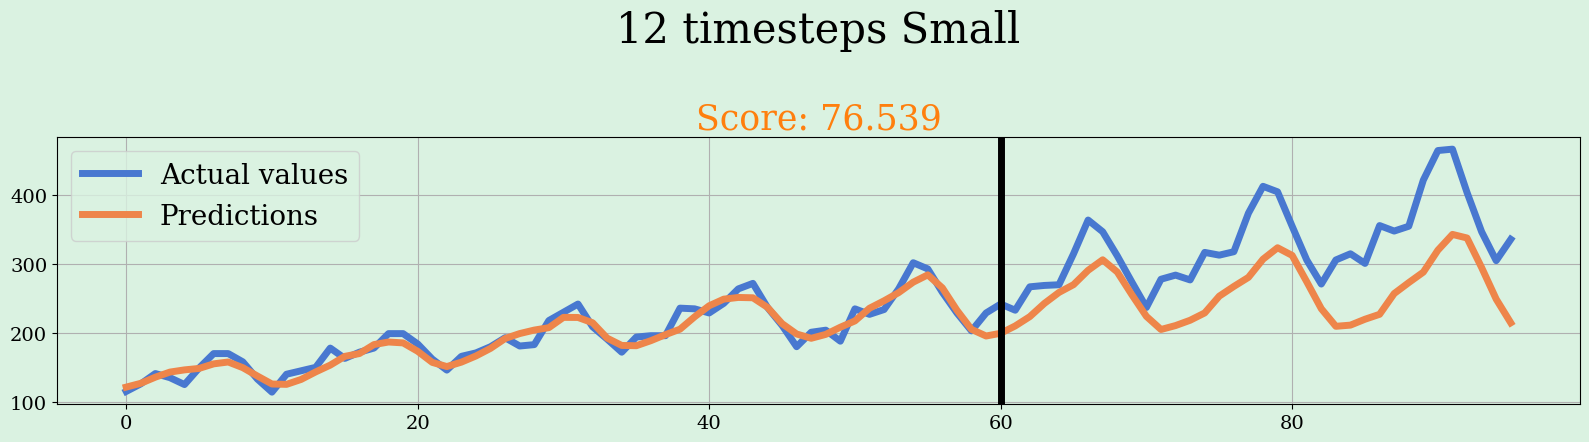

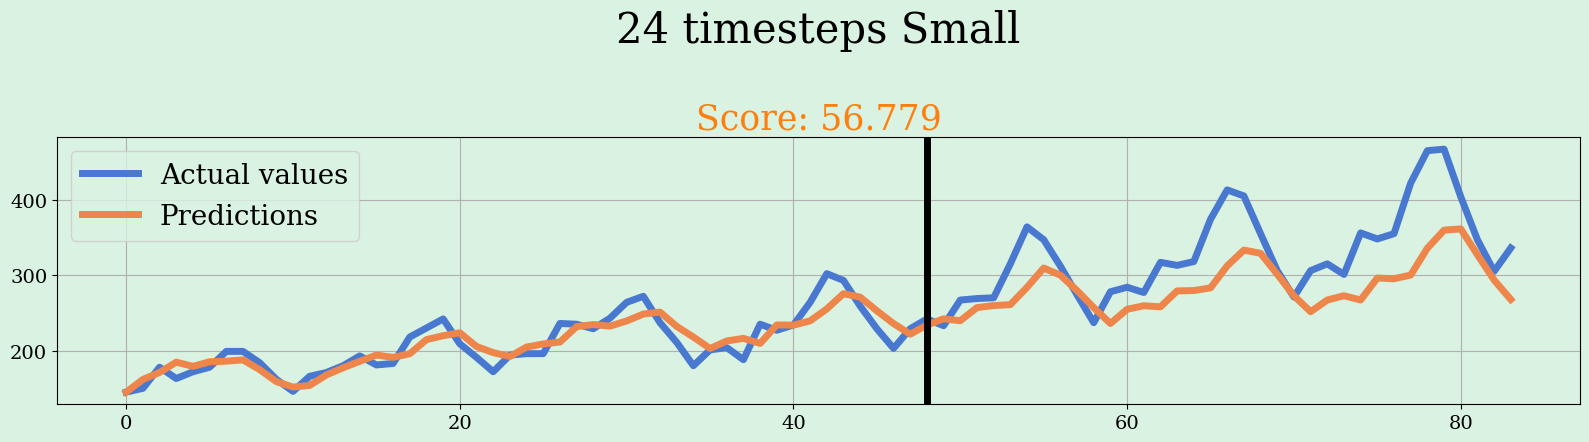

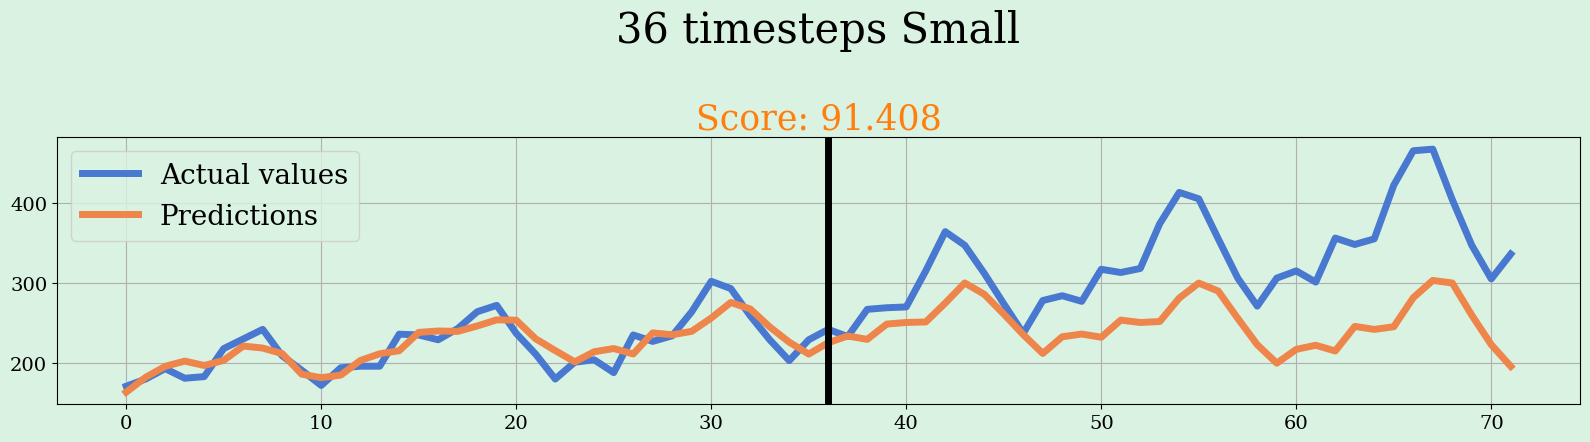

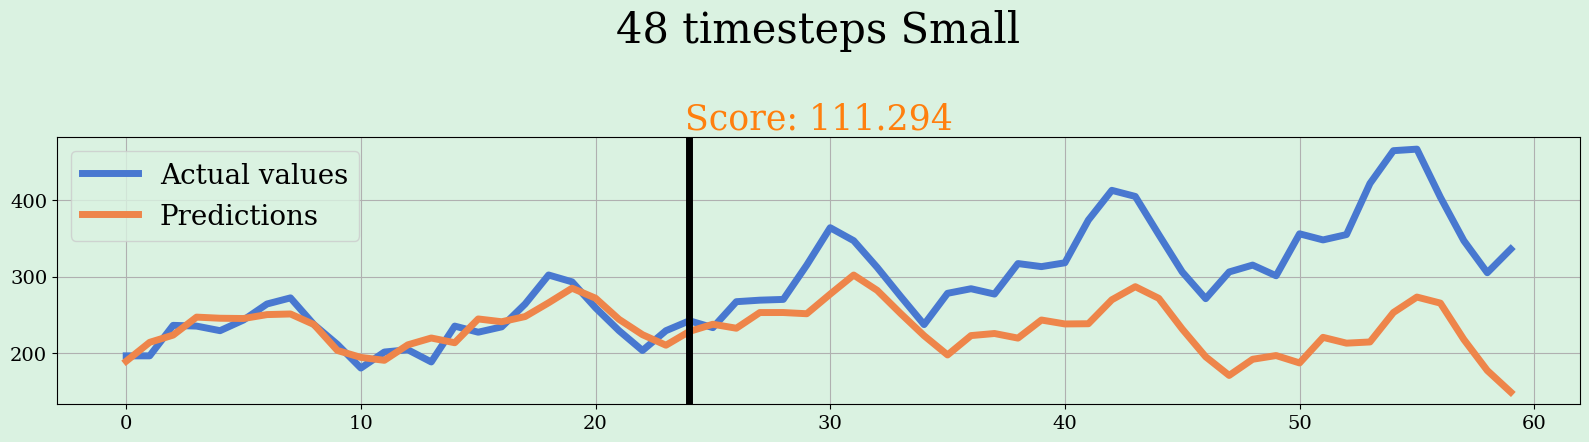

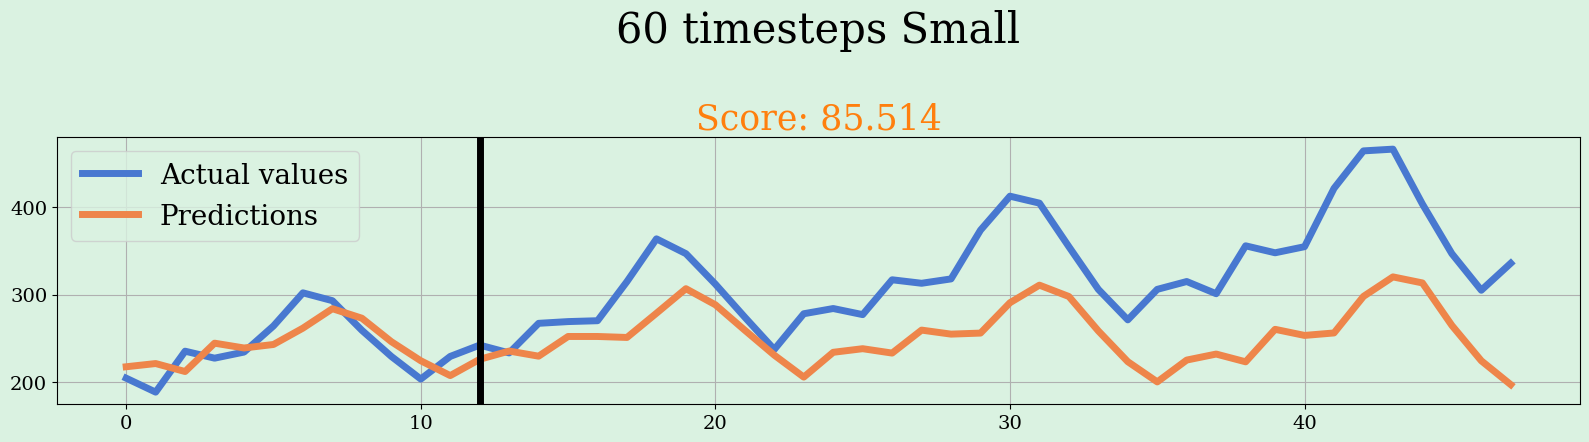

In [114]:
model_name = 'Small'
small_model = Sequential([
    LSTM(30),
    Dense(20, activation='relu'),
    Dense(1)
])
score_df = \
    evaluate_on_multiple_sets(datasets, small_model, model_name, score_df,
                              use_saved=True)

In [106]:
# pd.read_csv('Models/ 12 timesteps Small.h5')
import os
os.path.exists('Models/ 12 timesteps Small.h5')

True

Small model performs quite good on 12-period training sets, but not enough
for longer sets

## Medium model

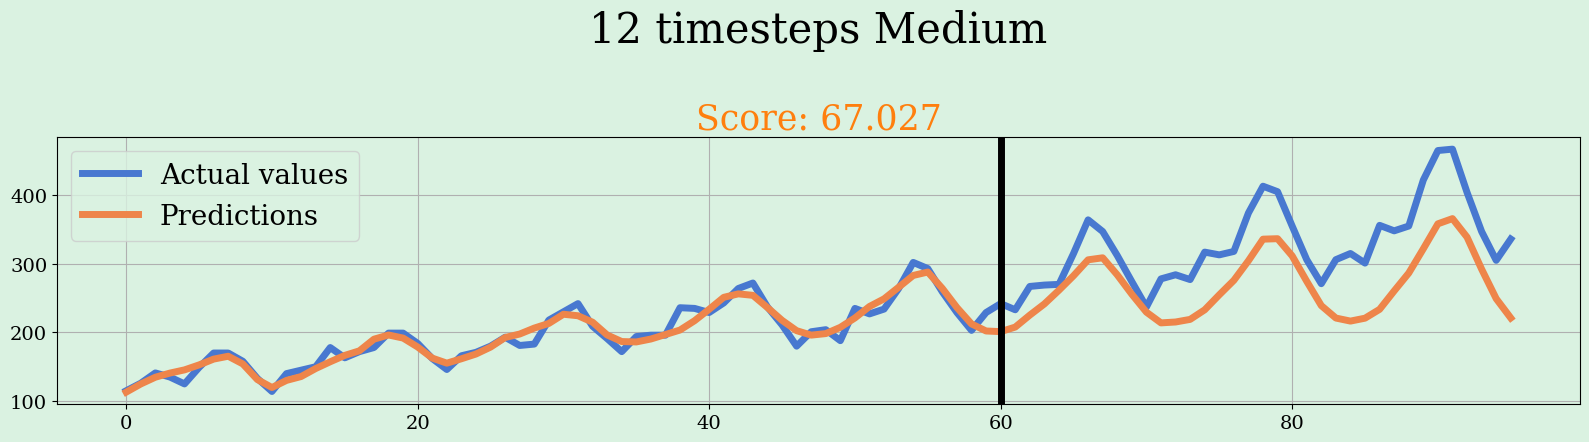

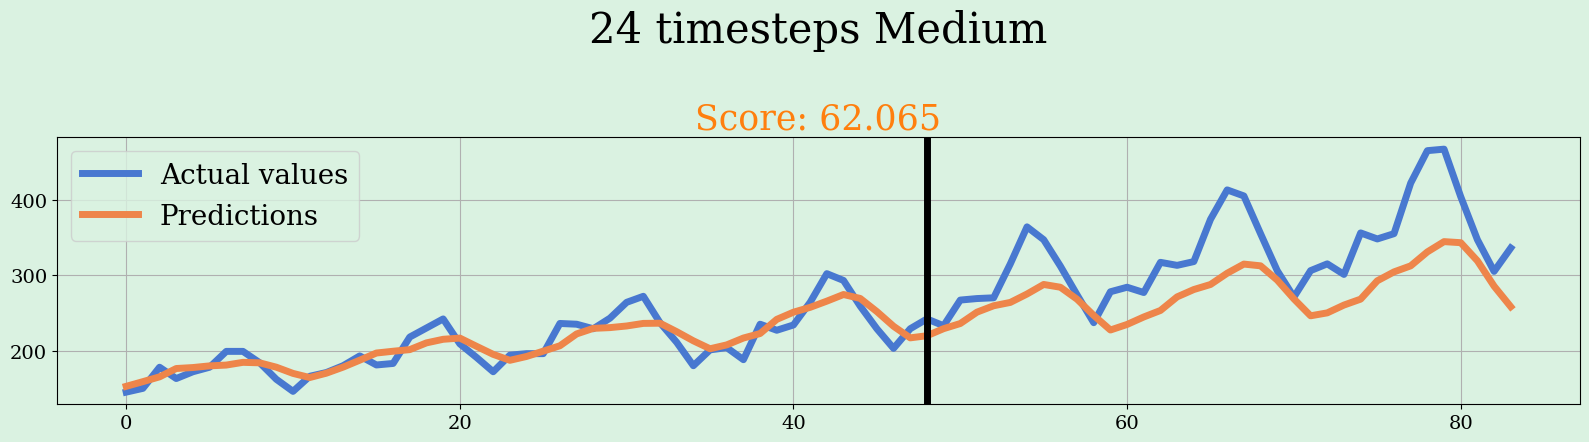

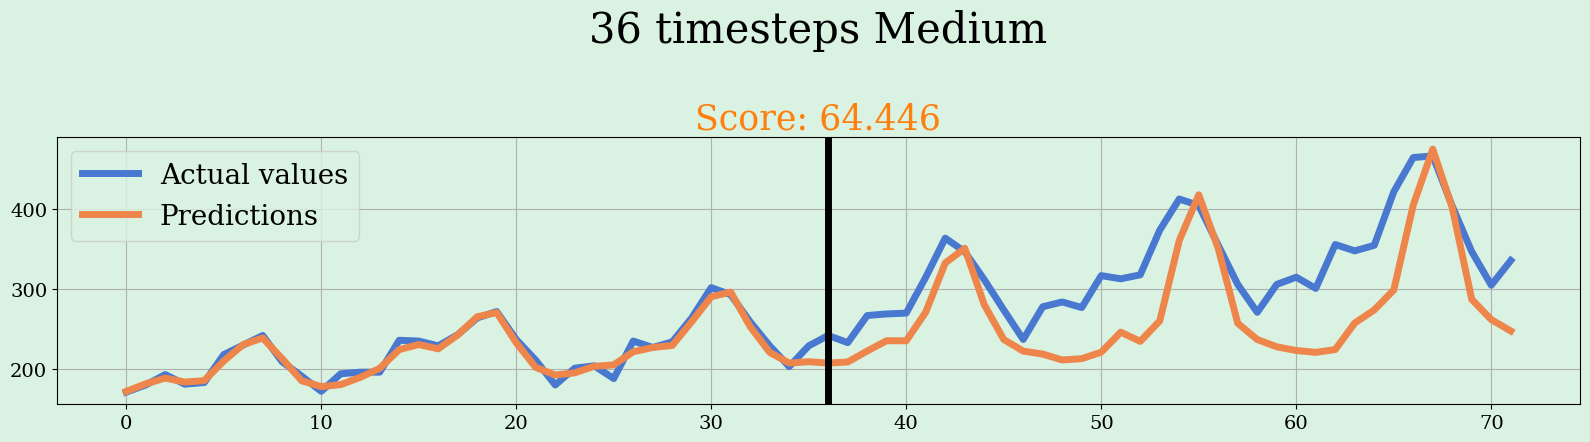

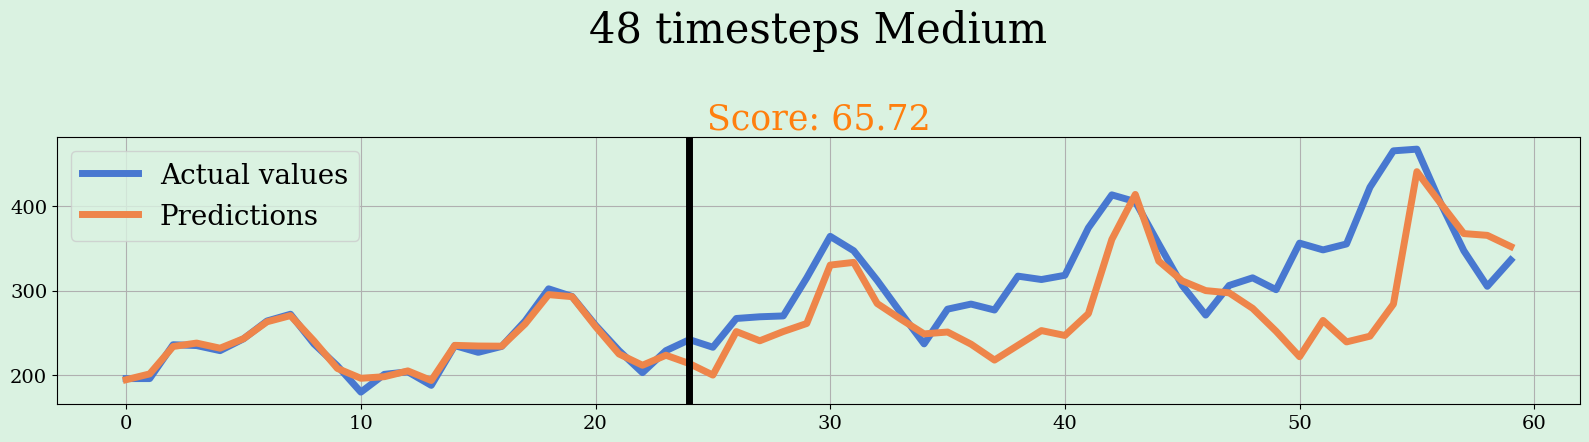

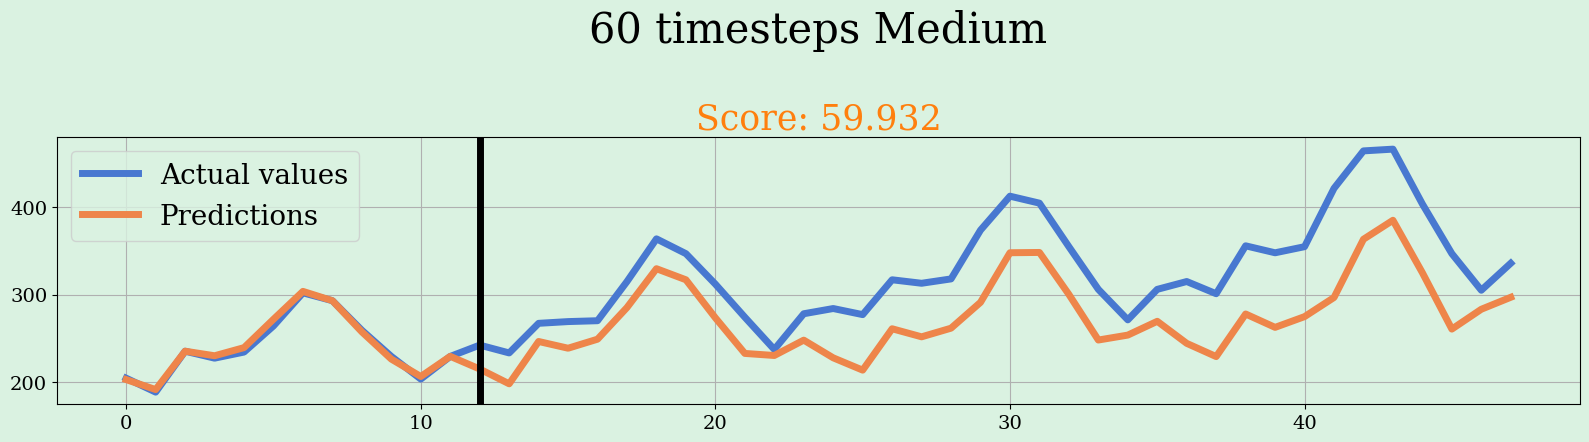

In [32]:
model_name = 'Medium'
medium_model = Sequential([
    LSTM(200),
    Dense(50, activation='relu'),
    Dense(1)
])
score_df = \
    evaluate_on_multiple_sets(datasets, medium_model, model_name, score_df)

Medium model in some cases can follow the upward trend and understand that
magnitude is increasing, but is unable to understand values during the low
season.

## Large model

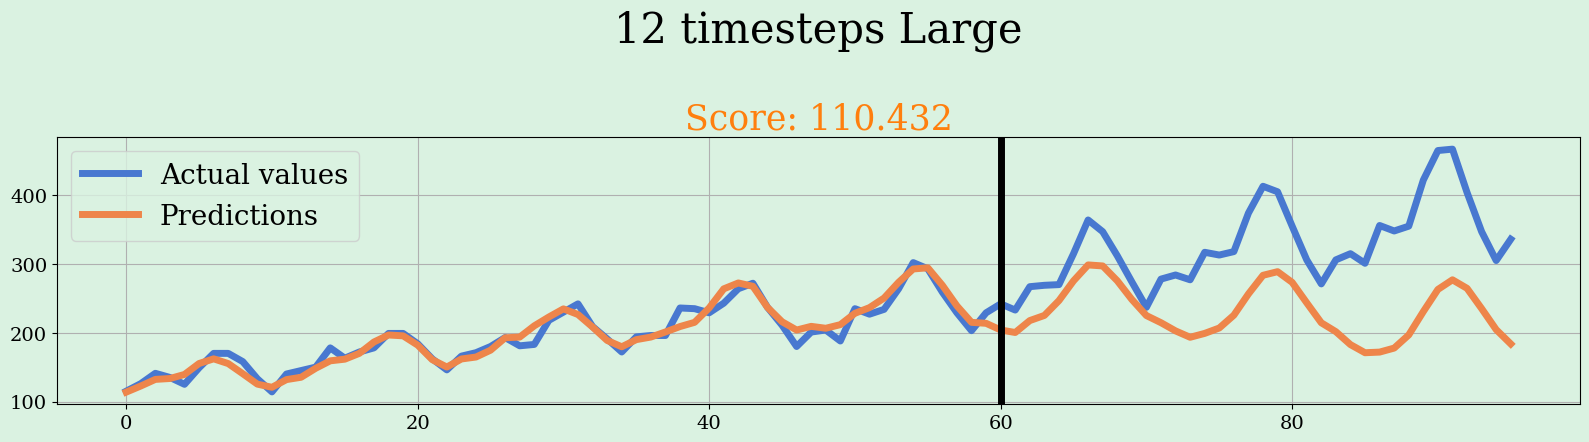

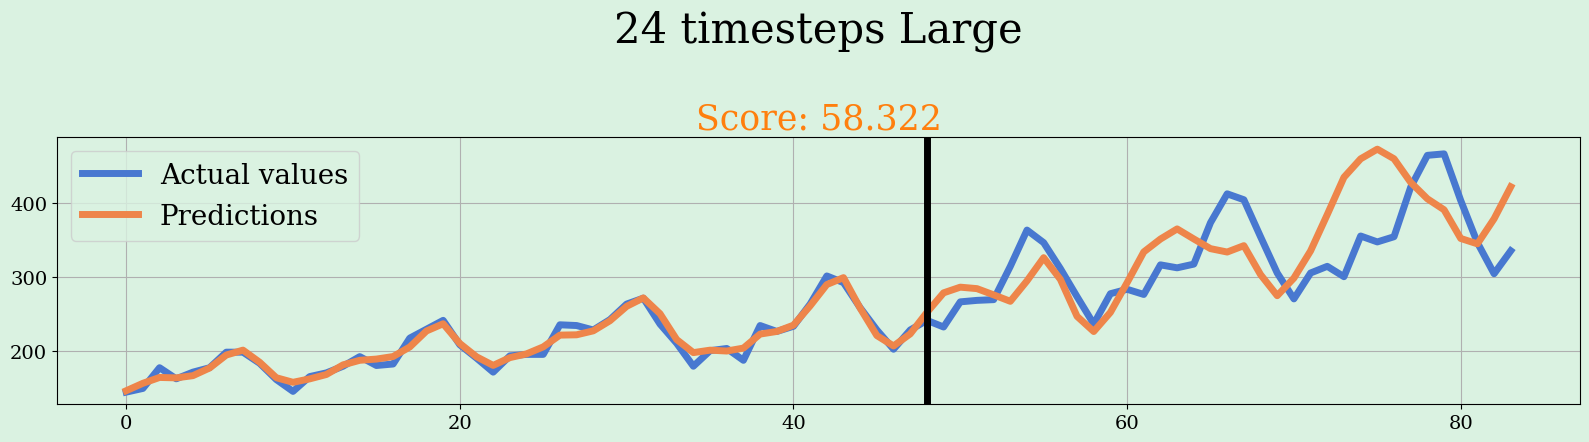

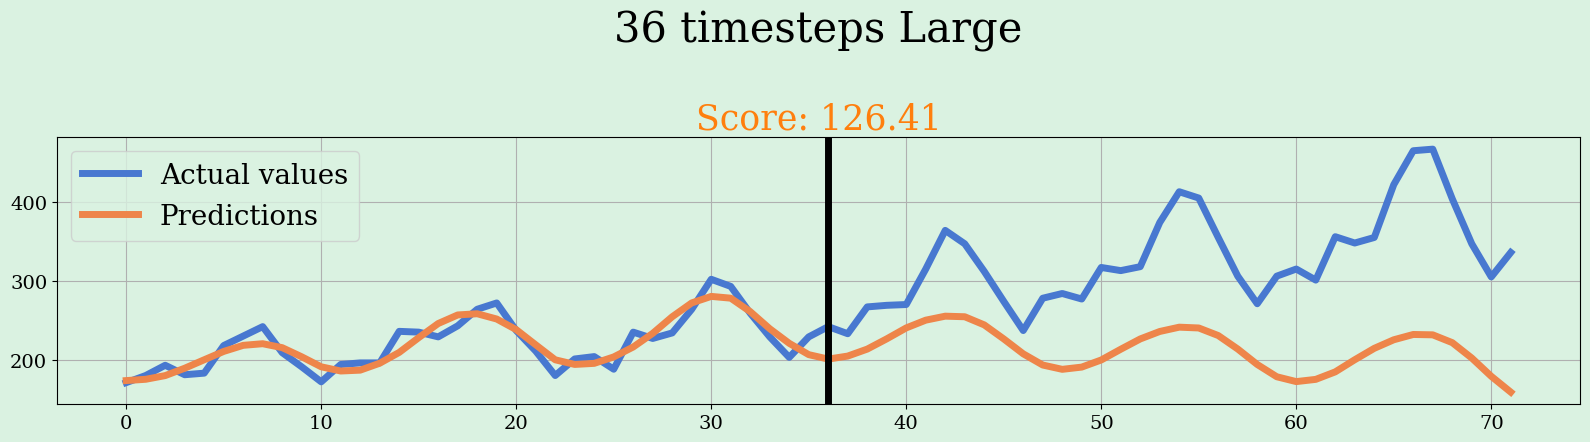

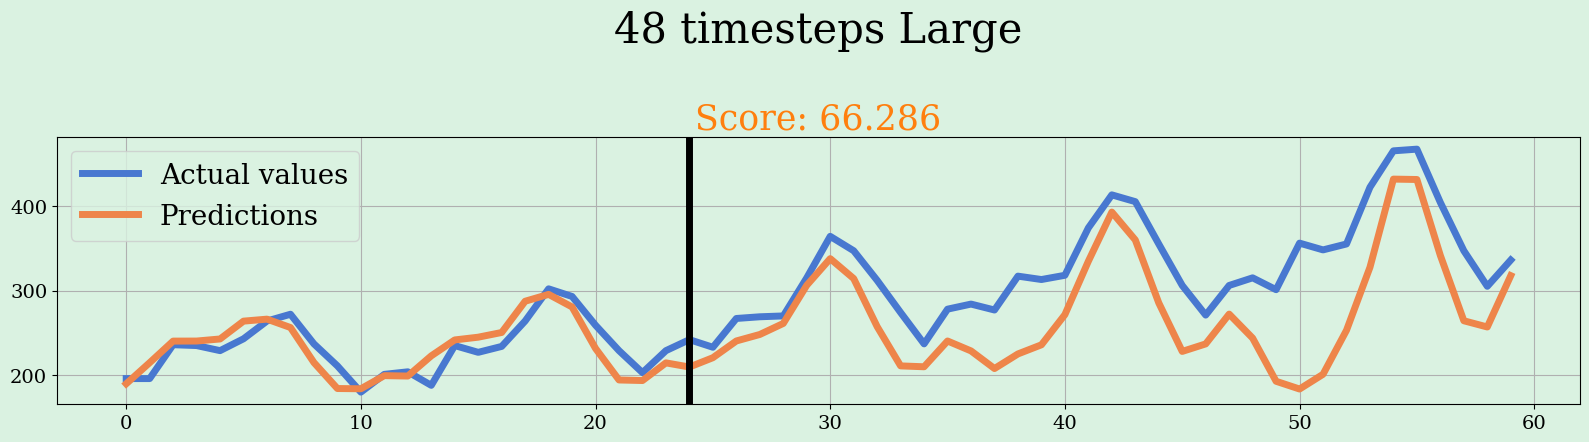

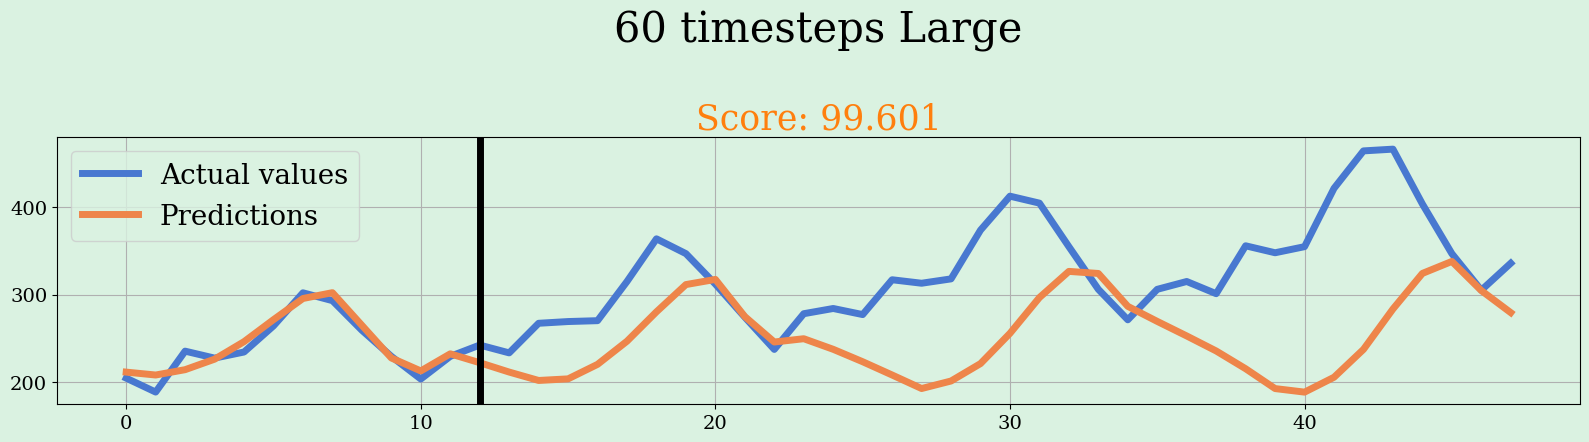

In [33]:
model_name = 'Large'
large_model = Sequential([
    LSTM(300, return_sequences=True),
    LSTM(200),
    Dense(100, activation='relu'),
    Dense(1)
])
score_df = \
    evaluate_on_multiple_sets(datasets, large_model, model_name, score_df)

Large model seems to be effective only on 24-period window.

## Multi-layer model

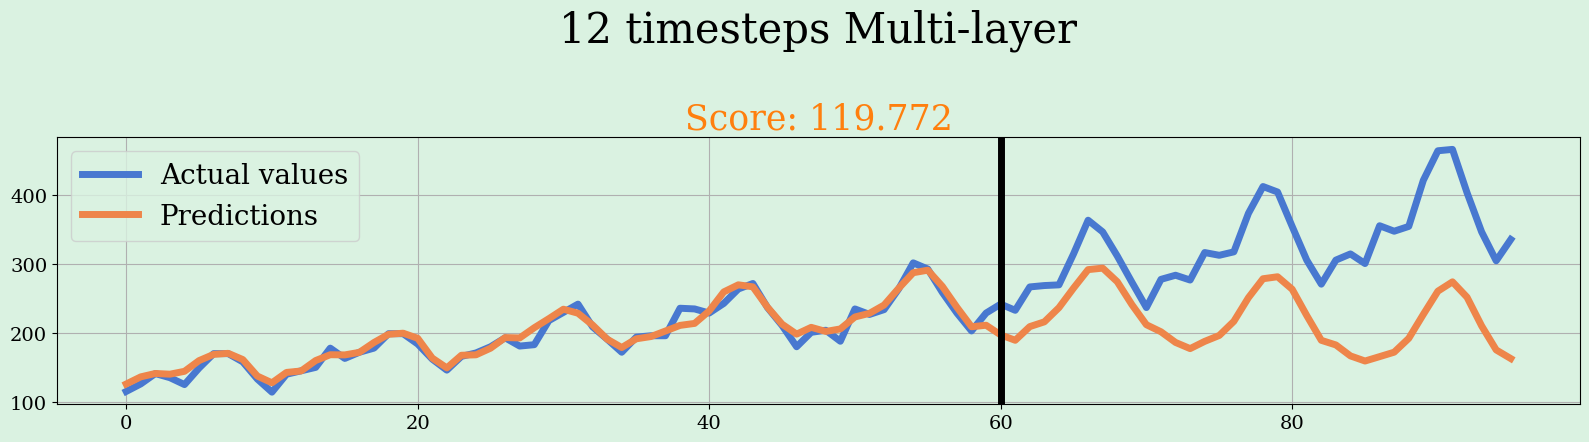

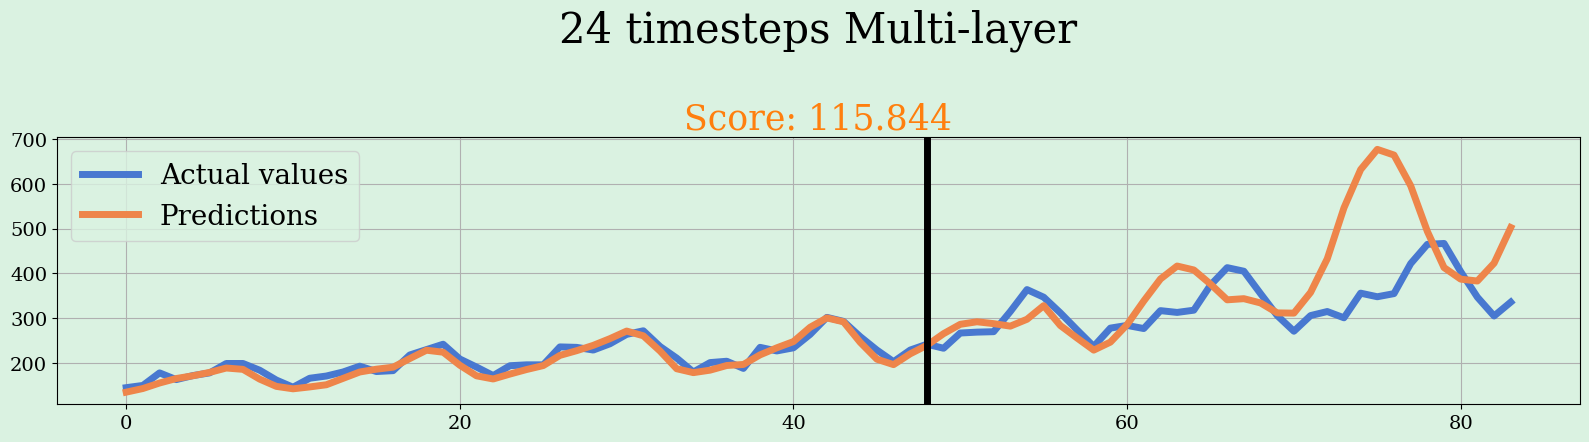

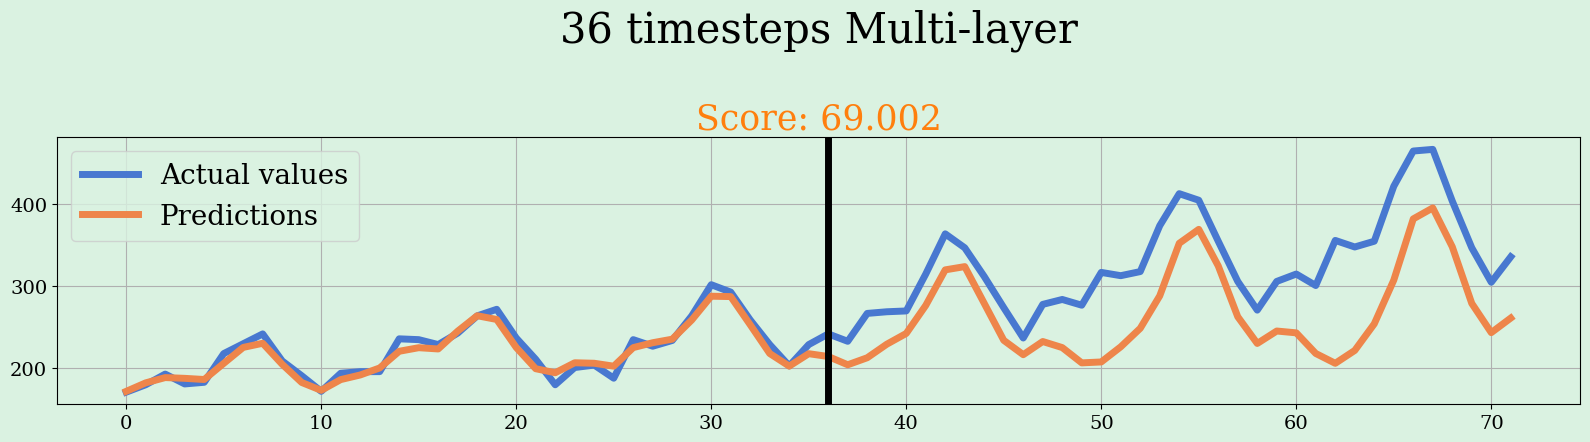

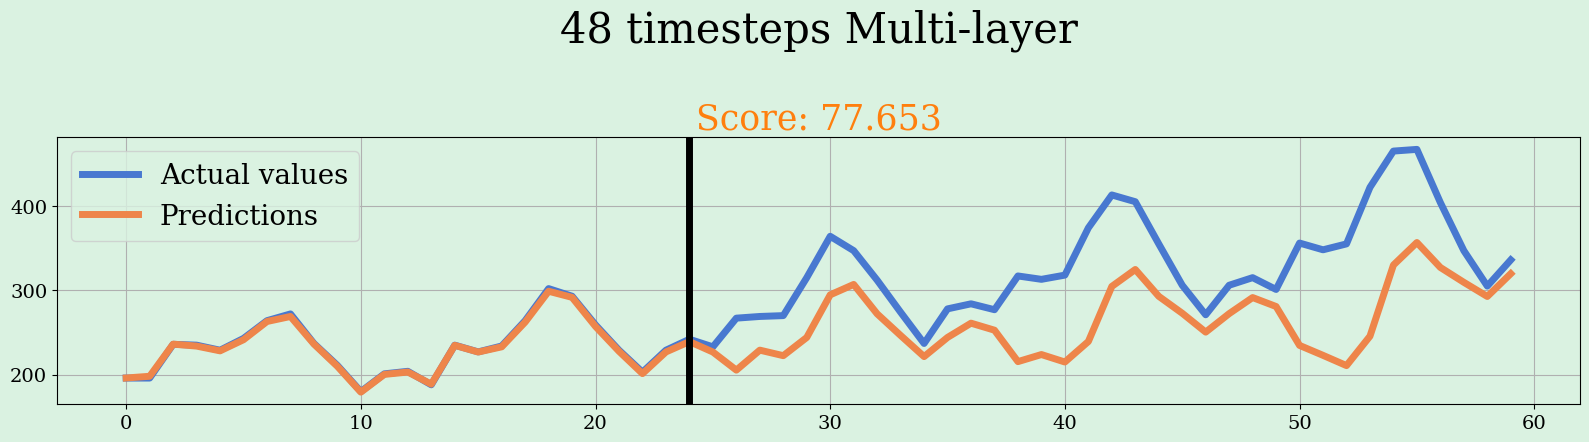

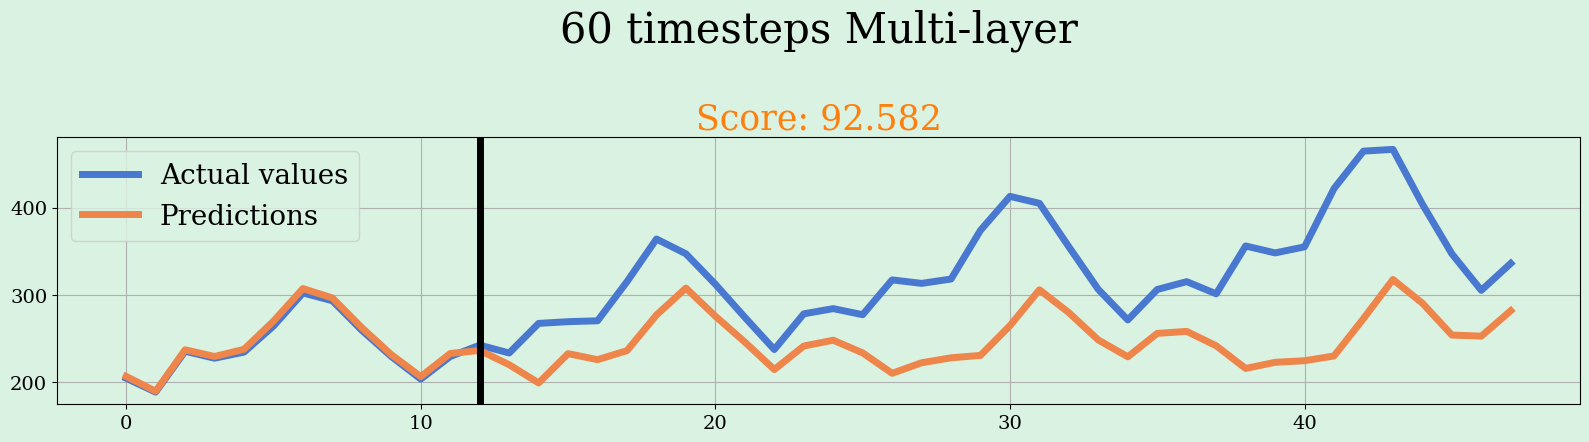

In [34]:
model_name = 'Multi-layer'
multi_model = Sequential([
    LSTM(300, return_sequences=True),
    LSTM(200),
    Dense(300, activation='relu'),
    Dense(100, activation='relu'),
    Dense(1),
])
score_df = \
    evaluate_on_multiple_sets(datasets, multi_model, model_name, score_df)

Multi-layer (LSTM) model

## Huge model

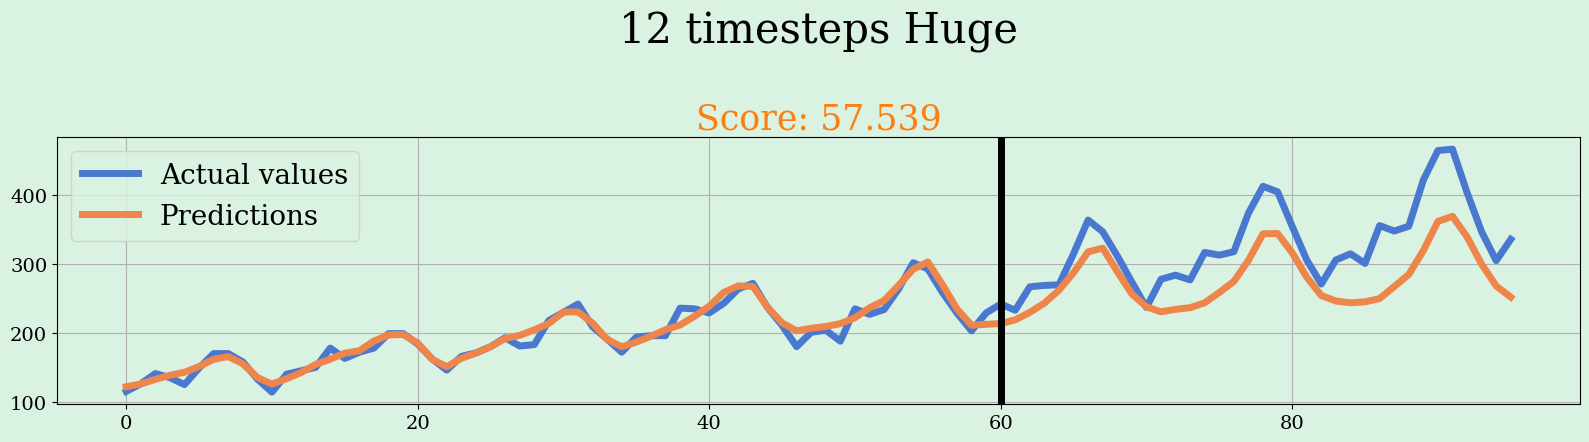

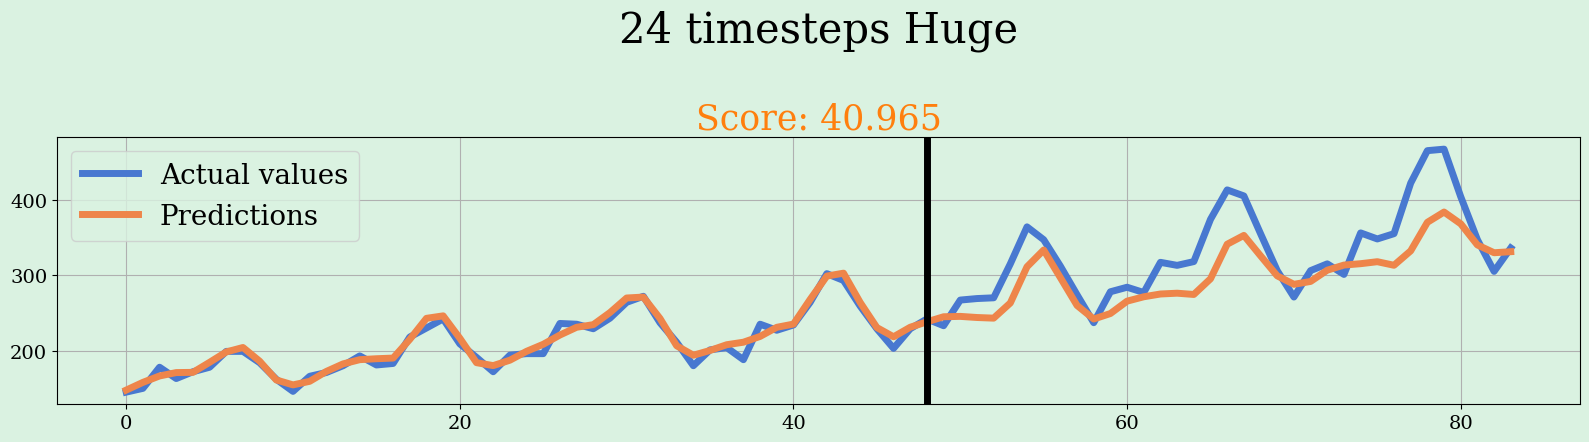

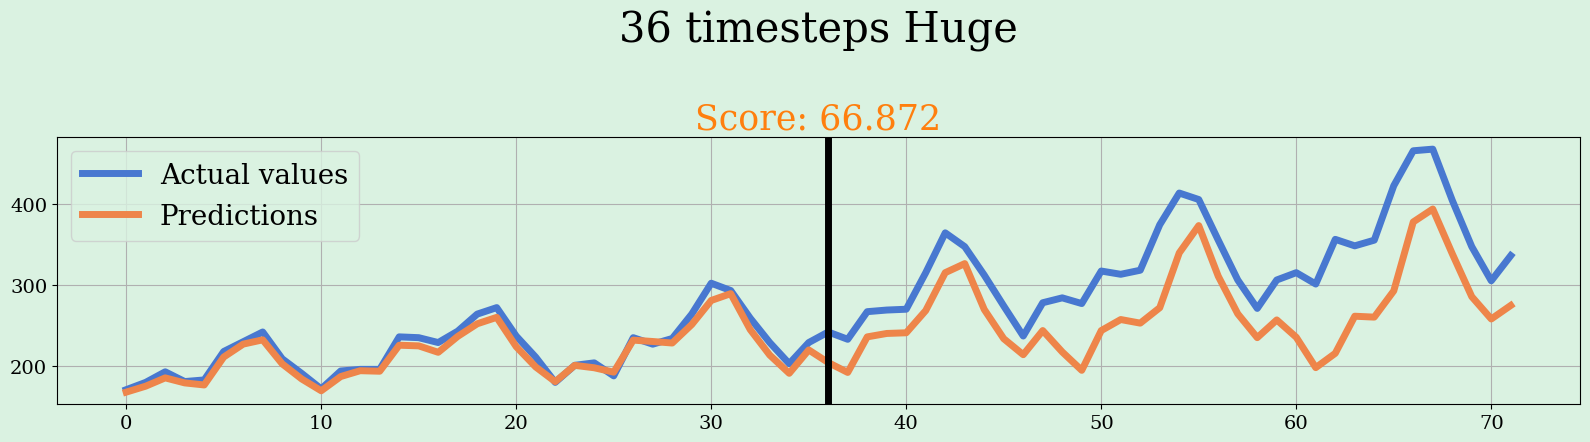

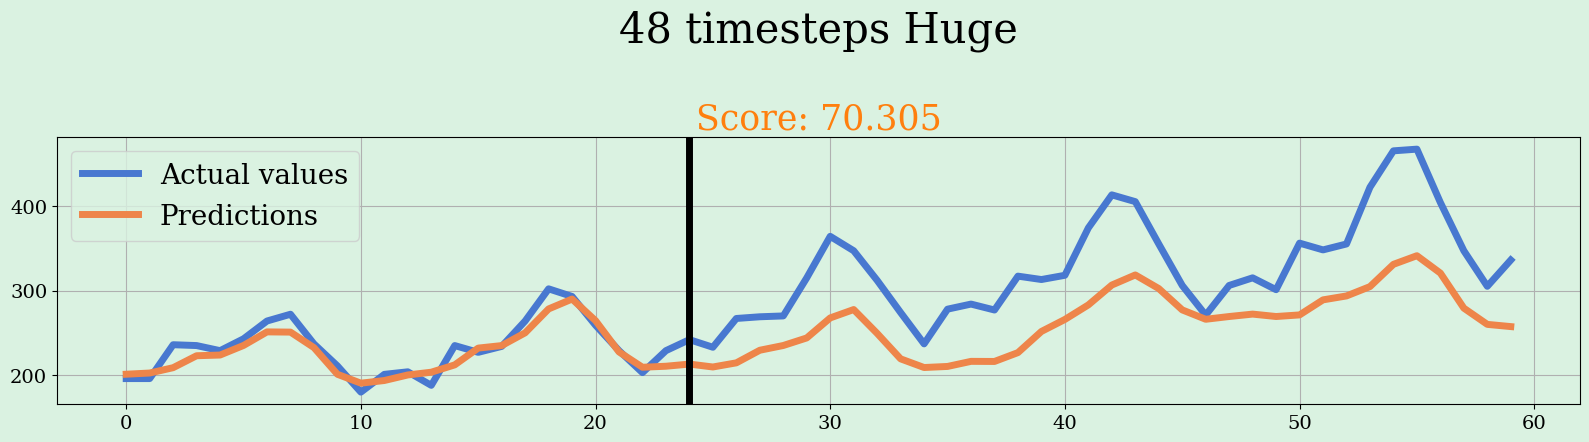

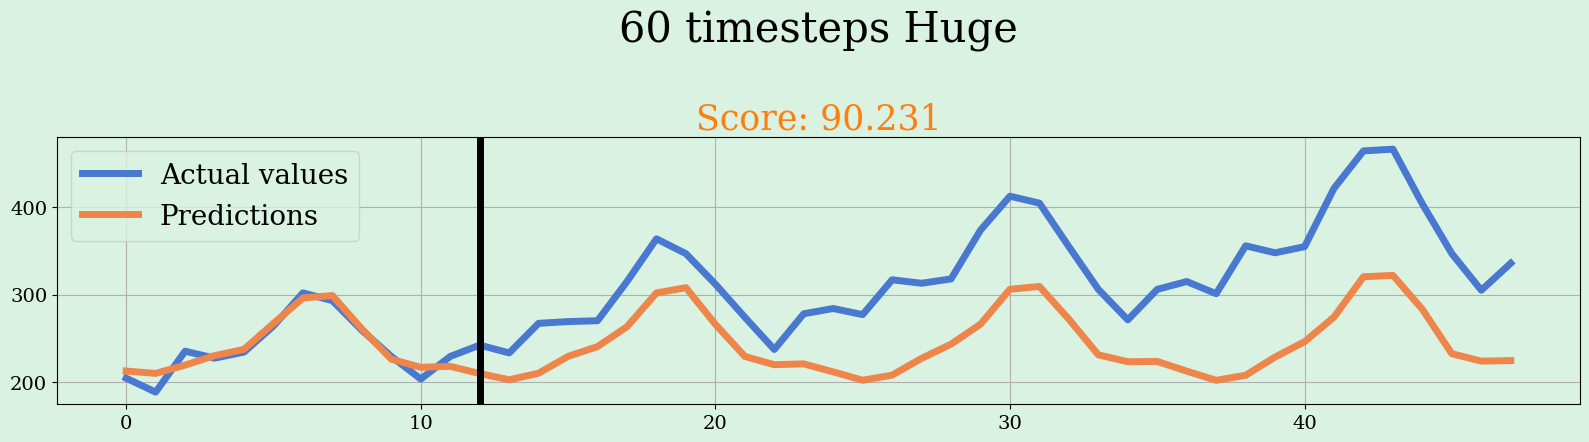

In [35]:
model_name = 'Huge'
multi_model = Sequential([
    LSTM(600),
    Dense(300, activation='relu'),
    Dense(100, activation='relu'),
    Dense(1),
])
score_df = \
    evaluate_on_multiple_sets(datasets, multi_model, model_name, score_df)

Huge model show the best results on 24 timesteps, but can be improved.

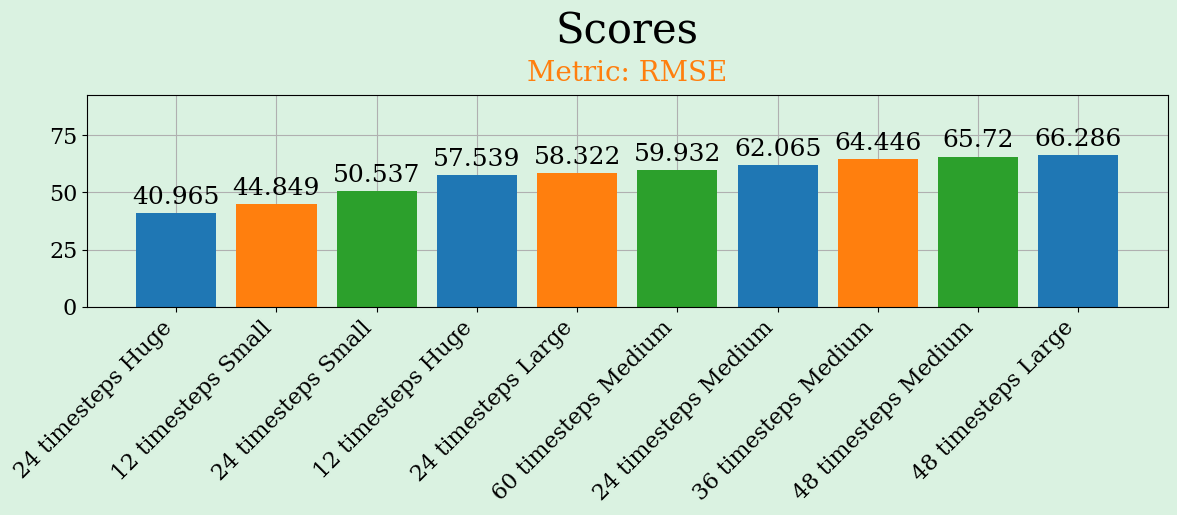

In [78]:
plot_model_results(score_df, 'RMSE')

# Work with 36 timesteps or 24 timesteps and huge model
### Need to reduce overfitting
* Early stopping already used
* Use dropout
* Use L2 regularization for dense layers

In [39]:
best_models_score = pd.DataFrame(columns=['ModelName', 'Score'])

# 36 timesteps

In [46]:
X_train_36, y_train_36, X_val_36, y_val_36 = \
    create_data(series_sc, train_sc, validation_sc, timesteps=36)
X_train_36.shape, y_train_36.shape

((36, 36, 1), (36, 1))

# Dropout 0.2

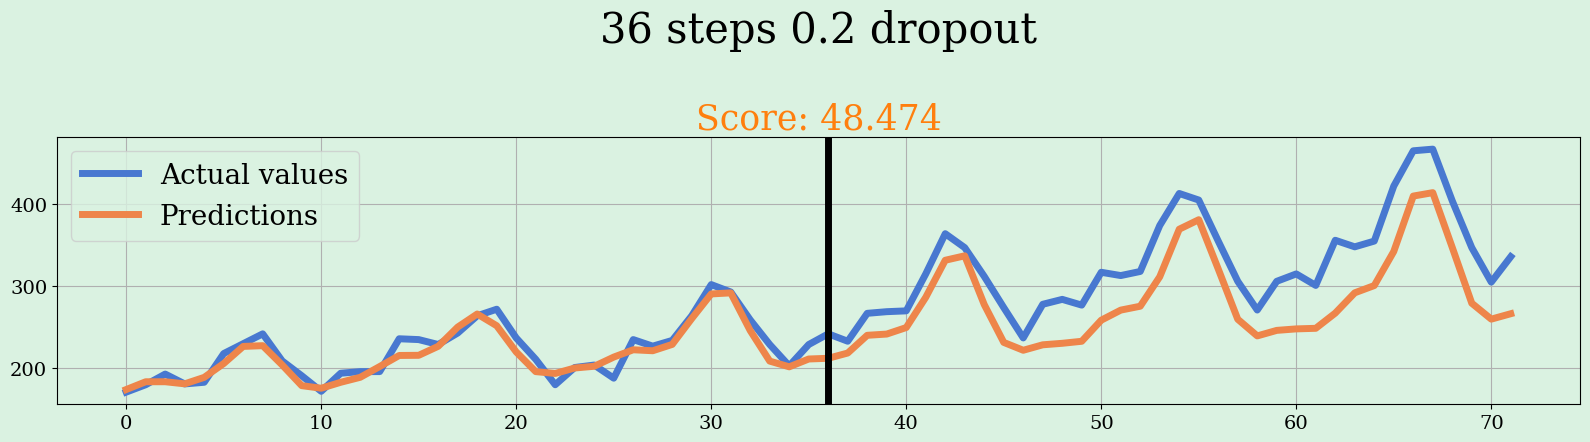

In [47]:
model_name = '36 steps 0.2 dropout'
multi_model = Sequential([
    LSTM(600),
    Dropout(0.2),
    Dense(300, activation='relu'),
    Dropout(0.2),
    Dense(100, activation='relu'),
    Dropout(0.2),
    Dense(1),
])
history = compile_fit_model(X_train_36, y_train_36, X_val_36, y_val_36,
                            multi_model, callbacks=[early_stopping],
                            model_name=model_name)
score = evaluate_model(X_train_36, y_train_36, X_val_36, y_val_36,
                       multi_model, history, model_name=model_name)
best_models_score = update_scores(best_models_score, model_name, score)
save_model(multi_model, model_name)

# Dropout 0.4

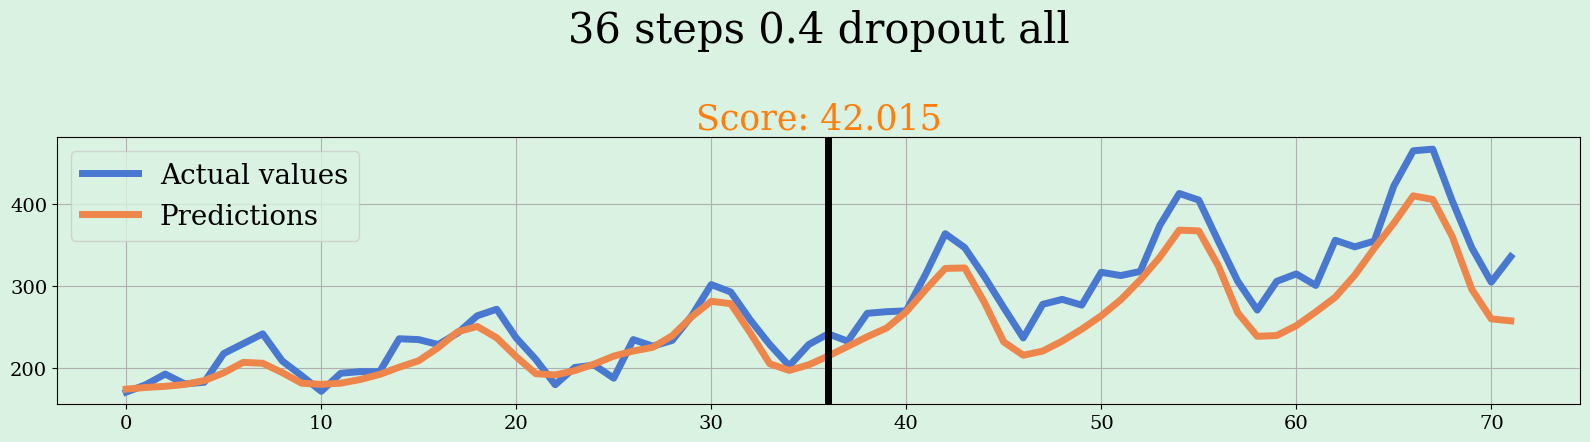

In [48]:
model_name = '36 steps 0.4 dropout'
multi_model = Sequential([
    LSTM(600),
    Dropout(0.4),
    Dense(300, activation='relu'),
    Dropout(0.4),
    Dense(100, activation='relu'),
    Dropout(0.4),
    Dense(1),
])
history = compile_fit_model(X_train_36, y_train_36, X_val_36, y_val_36,
                            multi_model, callbacks=[early_stopping])
score = evaluate_model(X_train_36, y_train_36, X_val_36, y_val_36,
                       multi_model, history, model_name=model_name)
best_models_score = update_scores(best_models_score, model_name, score)
save_model(multi_model, model_name)

# Dropout 0.4 only after large Dense layer

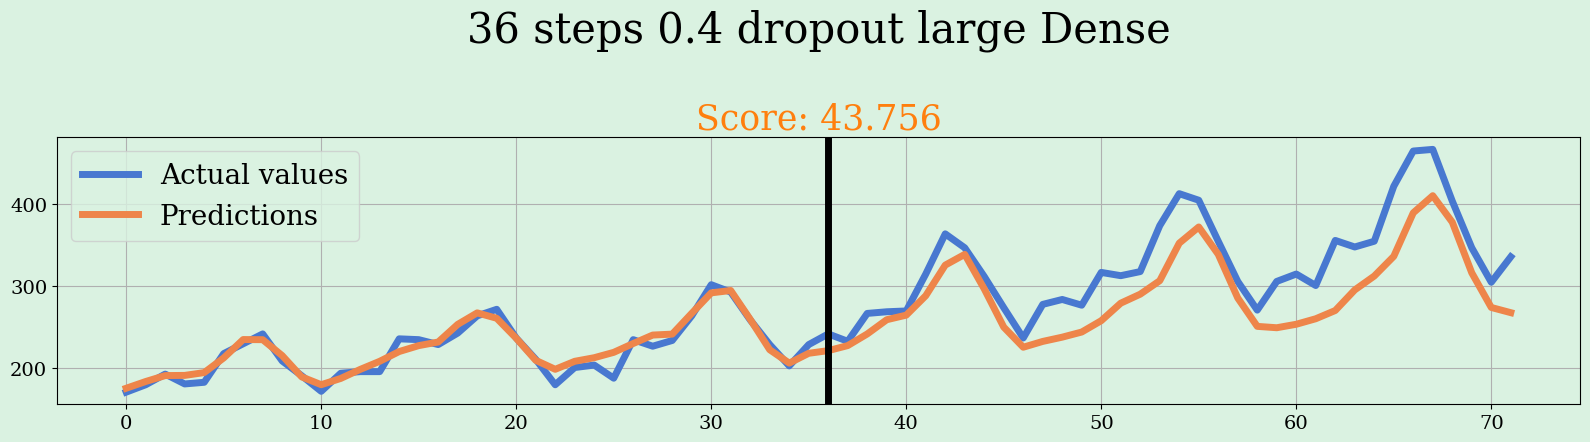

In [50]:
model_name = '36 steps 0.4 dropout large Dense'
multi_model = Sequential([
    LSTM(600),
    Dense(300, activation='relu'),
    Dropout(0.4),
    Dense(100, activation='relu'),
    Dense(1),
])
history = compile_fit_model(X_train_36, y_train_36, X_val_36, y_val_36,
                            multi_model, callbacks=[early_stopping])
score = evaluate_model(X_train_36, y_train_36, X_val_36, y_val_36,
                       multi_model, history, model_name=model_name)
best_models_score = update_scores(best_models_score, model_name, score)
save_model(multi_model, model_name)

# Dropout 0.5

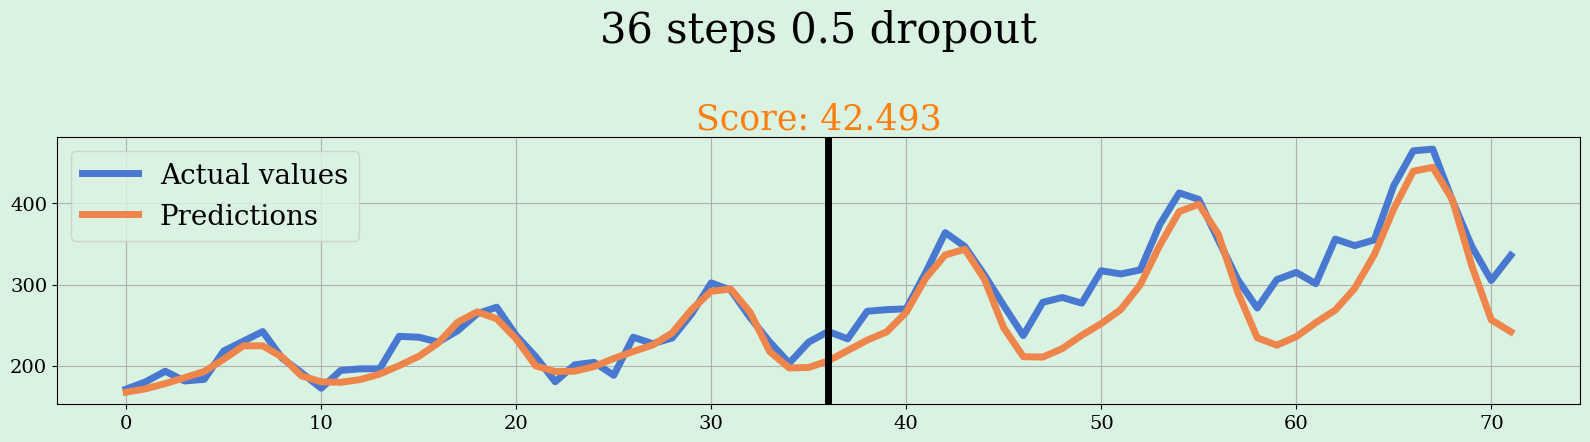

In [51]:
model_name = '36 steps 0.5 dropout'
multi_model = Sequential([
    LSTM(600),
    Dropout(0.5),
    Dense(300, activation='relu'),
    Dropout(0.5),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(1),
])
history = compile_fit_model(X_train_36, y_train_36, X_val_36, y_val_36,
                            multi_model, callbacks=[early_stopping])
score = evaluate_model(X_train_36, y_train_36, X_val_36, y_val_36,
                       multi_model, history, model_name=model_name)
best_models_score = update_scores(best_models_score, model_name, score)
save_model(multi_model, model_name)

# Dropout 0.6

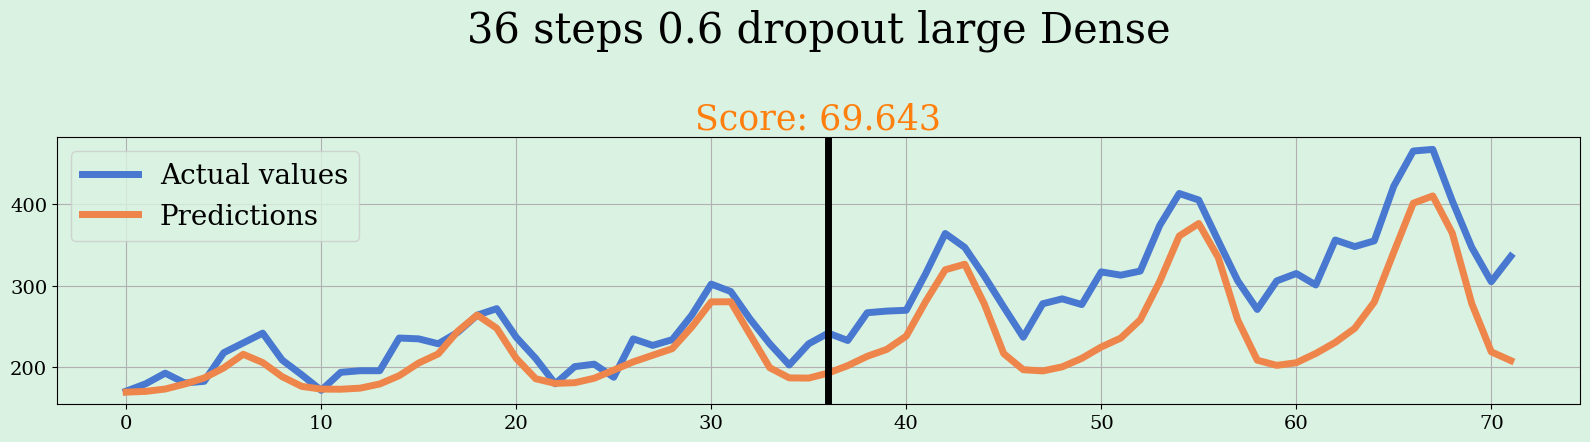

In [52]:
model_name = '36 steps 0.6 dropout large Dense'
multi_model = Sequential([
    LSTM(600),
    Dropout(0.6),
    Dense(300, activation='relu'),
    Dropout(0.6),
    Dense(100, activation='relu'),
    Dropout(0.6),
    Dense(1),
])
history = compile_fit_model(X_train_36, y_train_36, X_val_36, y_val_36,
                            multi_model, callbacks=[early_stopping])
score = evaluate_model(X_train_36, y_train_36, X_val_36, y_val_36,
                       multi_model, history, model_name=model_name)
best_models_score = update_scores(best_models_score, model_name, score)
save_model(multi_model, model_name)

# L2 regularization

# Dropout 0.4 + L2 kernel regularizer 0.001

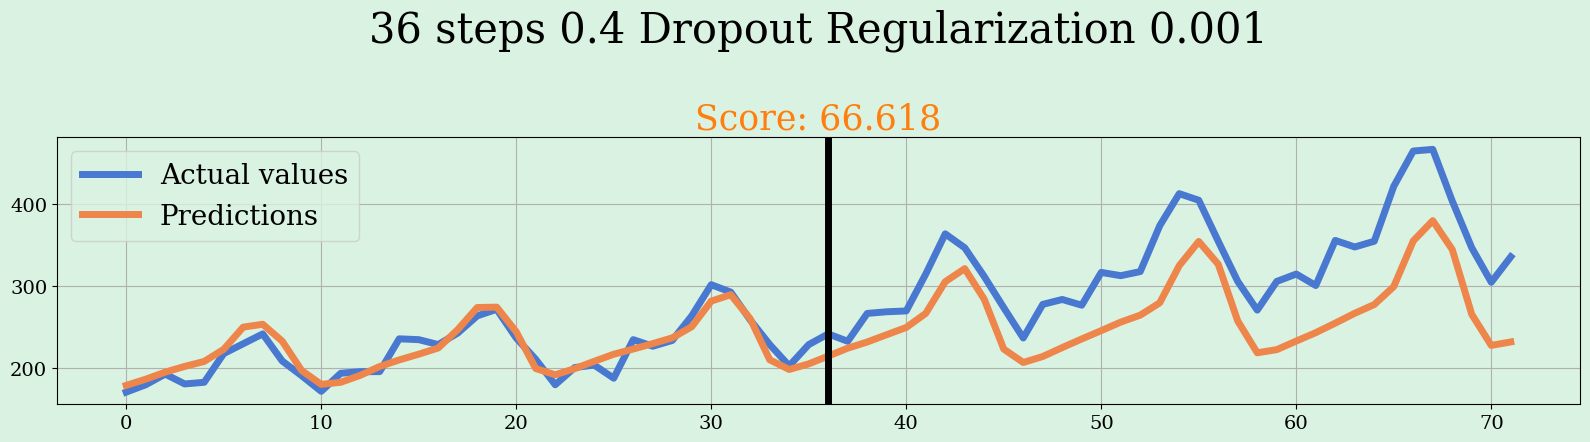

In [53]:
model_name = '36 steps 0.4 Dropout Regularization 0.001'
multi_model = Sequential([
    LSTM(600),
    Dropout(0.4),
    Dense(300, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(100, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(1)
])
history = compile_fit_model(X_train_36, y_train_36, X_val_36, y_val_36,
                            multi_model, callbacks=[early_stopping],
                            verbose=0)
score = evaluate_model(X_train_36, y_train_36, X_val_36, y_val_36,
                       multi_model, history, model_name=model_name)
best_models_score = update_scores(best_models_score, model_name, score)
save_model(multi_model, model_name)

# Dropout 0.4 + L2 kernel regularizer 0.005

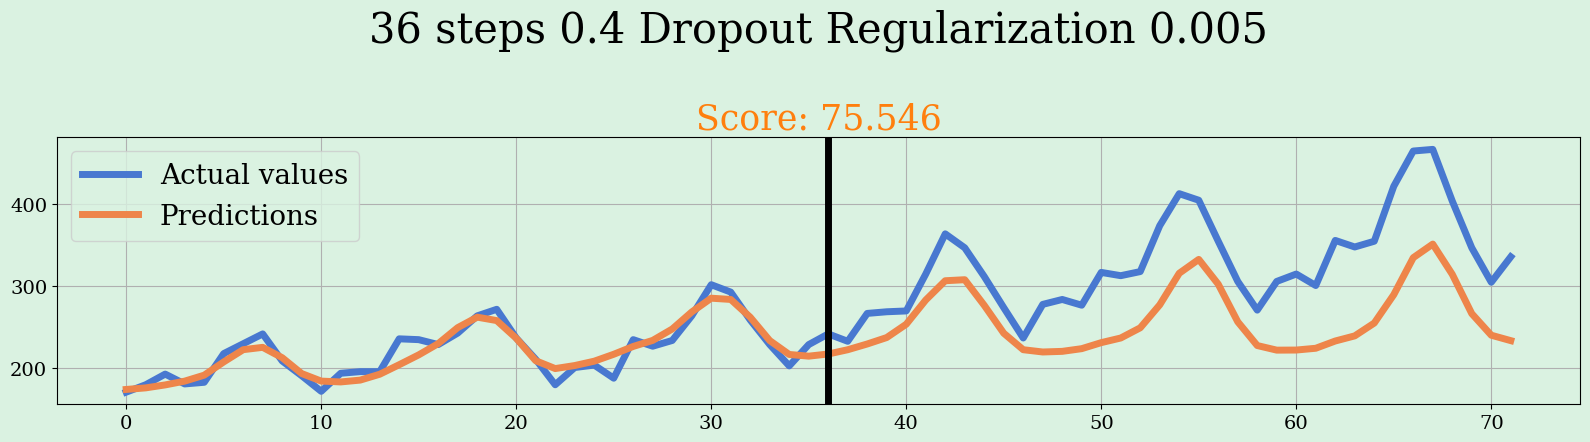

In [54]:
model_name = '36 steps 0.4 Dropout Regularization 0.005'
multi_model = Sequential([
    LSTM(600),
    Dropout(0.4),
    Dense(300, activation='relu', kernel_regularizer=l2(0.005)),
    Dropout(0.4),
    Dense(100, activation='relu', kernel_regularizer=l2(0.005)),
    Dropout(0.4),
    Dense(1)
])
history = compile_fit_model(X_train_36, y_train_36, X_val_36, y_val_36,
                            multi_model, callbacks=[early_stopping],
                            verbose=0)
score = evaluate_model(X_train_36, y_train_36, X_val_36, y_val_36,
                       multi_model, history, model_name=model_name)
best_models_score = update_scores(best_models_score, model_name, score)
save_model(multi_model, model_name)

# Dropout 0.4 + L2 kernel regularizer 0.0005

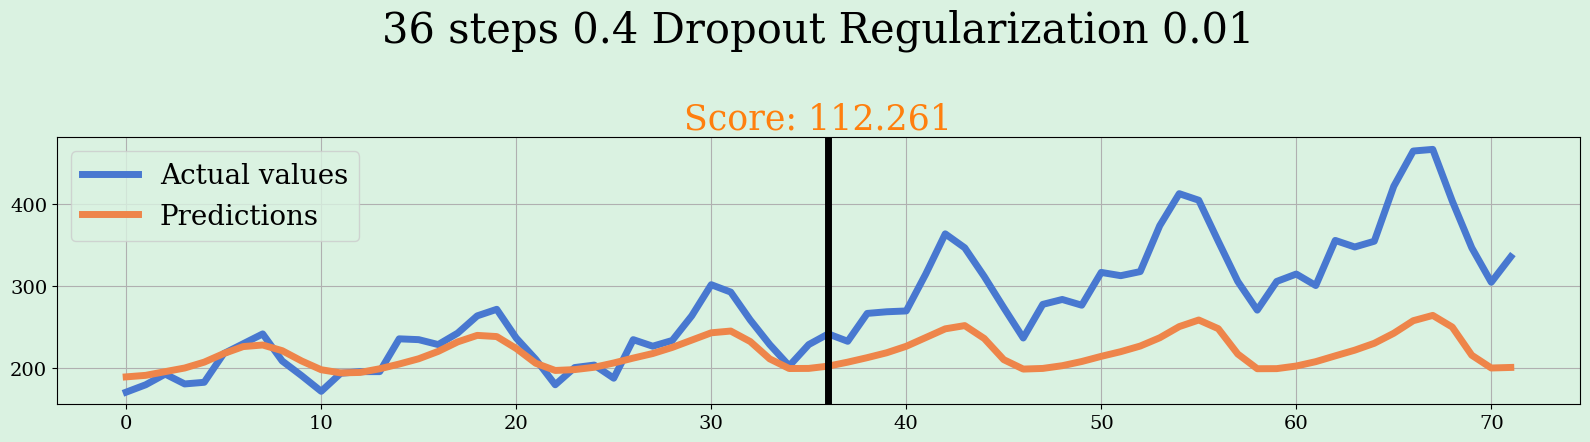

In [55]:
model_name = '36 steps 0.4 Dropout Regularization 0.01'
multi_model = Sequential([
    LSTM(600),
    Dropout(0.4),
    Dense(300, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.4),
    Dense(100, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.4),
    Dense(1)
])
history = compile_fit_model(X_train_36, y_train_36, X_val_36, y_val_36,
                            multi_model, callbacks=[early_stopping],
                            verbose=0)
score = evaluate_model(X_train_36, y_train_36, X_val_36, y_val_36,
                       multi_model, history, model_name=model_name)
best_models_score = update_scores(best_models_score, model_name, score)
save_model(multi_model, model_name)

# Dropout 0.4 + one extra dense layer

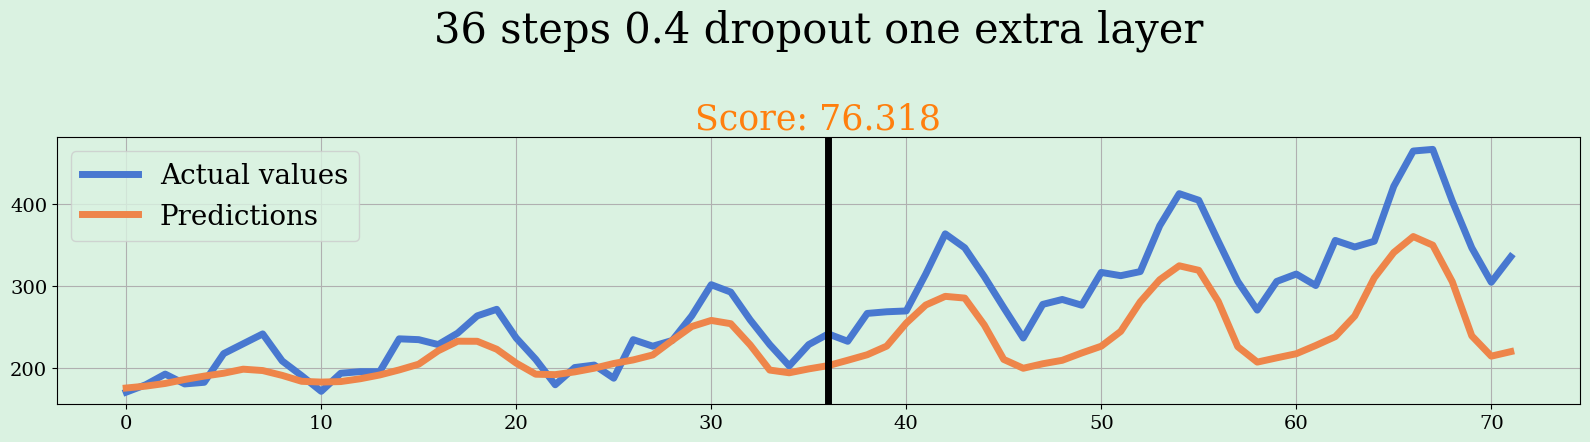

In [56]:
model_name = '36 steps 0.4 dropout one extra layer'
multi_model = Sequential([
    LSTM(600),
    Dropout(0.4),
    Dense(400, activation='relu'),
    Dropout(0.4),
    Dense(200, activation='relu'),
    Dropout(0.4),
    Dense(100, activation='relu'),
    Dropout(0.4),
    Dense(1),
])
history = compile_fit_model(X_train_36, y_train_36, X_val_36, y_val_36,
                            multi_model, callbacks=[early_stopping])
score = evaluate_model(X_train_36, y_train_36, X_val_36, y_val_36,
                       multi_model, history, model_name=model_name)
best_models_score = update_scores(best_models_score, model_name, score)
save_model(multi_model, model_name)

# 24 timesteps

In [37]:
X_train_24, y_train_24, X_val_24, y_val_24 = \
    create_data(series_sc, train_sc, validation_sc, timesteps=24)
X_train_24.shape, y_train_24.shape

((48, 24, 1), (48, 1))

# Dropout 0.2

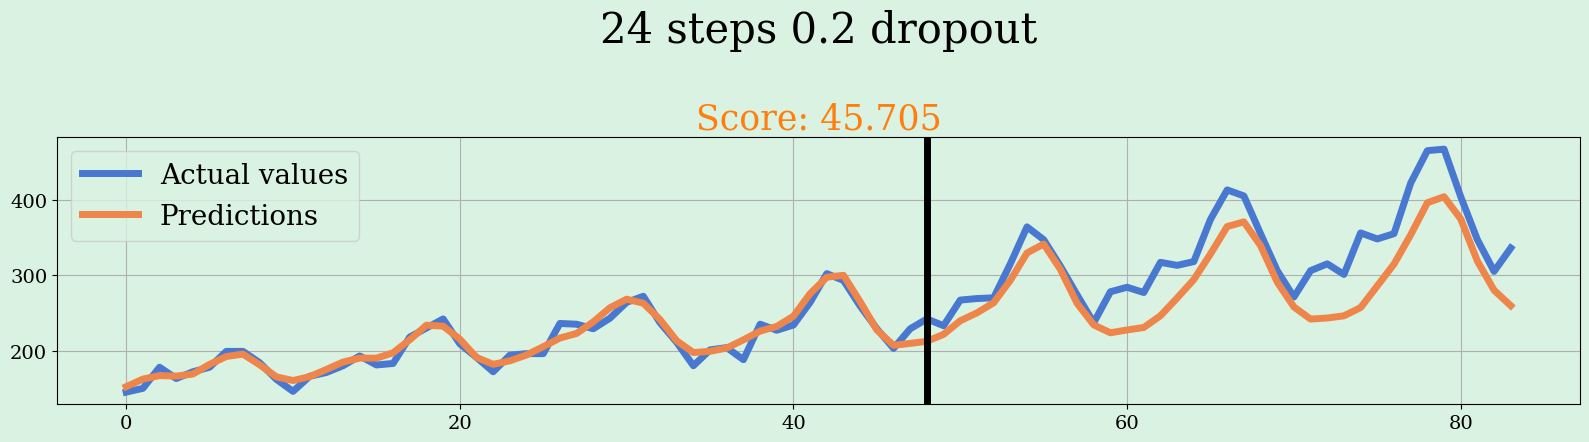

In [41]:
model_name = '24 steps 0.2 dropout'
multi_model = Sequential([
    LSTM(600),
    Dropout(0.2),
    Dense(300, activation='relu'),
    Dropout(0.2),
    Dense(100, activation='relu'),
    Dropout(0.2),
    Dense(1),
])
history = compile_fit_model(X_train_24, y_train_24, X_val_24, y_val_24,
                            multi_model, callbacks=[early_stopping])
score = evaluate_model(X_train_24, y_train_24, X_val_24, y_val_24,
                       multi_model, history, model_name=model_name)
best_models_score = update_scores(best_models_score, model_name, score)
save_model(multi_model, model_name)

# Dropout 0.3

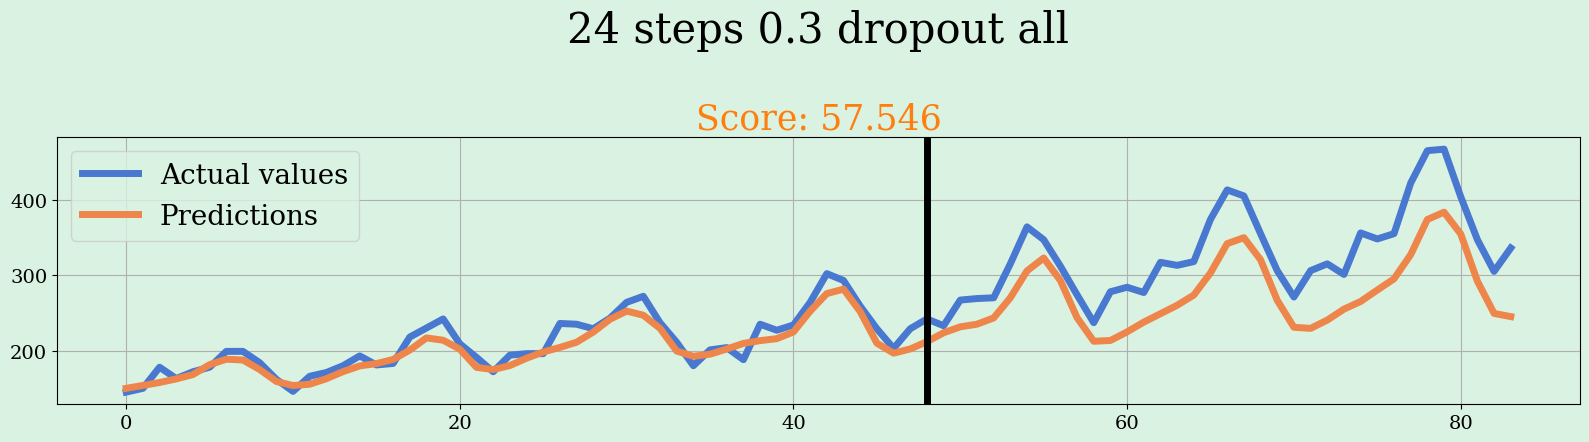

In [42]:
model_name = '24 steps 0.3 dropout'
multi_model = Sequential([
    LSTM(600),
    Dropout(0.3),
    Dense(300, activation='relu'),
    Dropout(0.3),
    Dense(100, activation='relu'),
    Dropout(0.3),
    Dense(1),
])
history = compile_fit_model(X_train_24, y_train_24, X_val_24, y_val_24,
                            multi_model, callbacks=[early_stopping])
score = evaluate_model(X_train_24, y_train_24, X_val_24, y_val_24,
                       multi_model, history, model_name=model_name)
best_models_score = update_scores(best_models_score, model_name, score)
save_model(multi_model, model_name)

# Dropout 0.4

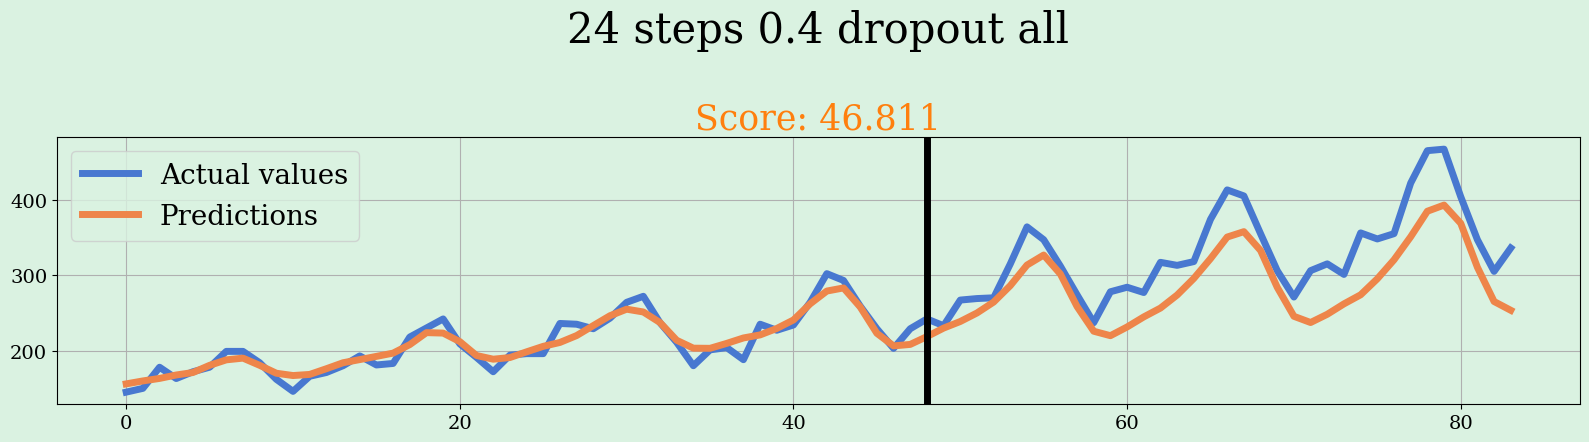

In [43]:
model_name = '24 steps 0.4 dropout'
multi_model = Sequential([
    LSTM(600),
    Dropout(0.4),
    Dense(300, activation='relu'),
    Dropout(0.4),
    Dense(100, activation='relu'),
    Dropout(0.4),
    Dense(1),
])
history = compile_fit_model(X_train_24, y_train_24, X_val_24, y_val_24,
                            multi_model, callbacks=[early_stopping])
score = evaluate_model(X_train_24, y_train_24, X_val_24, y_val_24,
                       multi_model, history, model_name=model_name)
best_models_score = update_scores(best_models_score, model_name, score)
save_model(multi_model, model_name)

# Dropout 0.4 + one extra dense layer

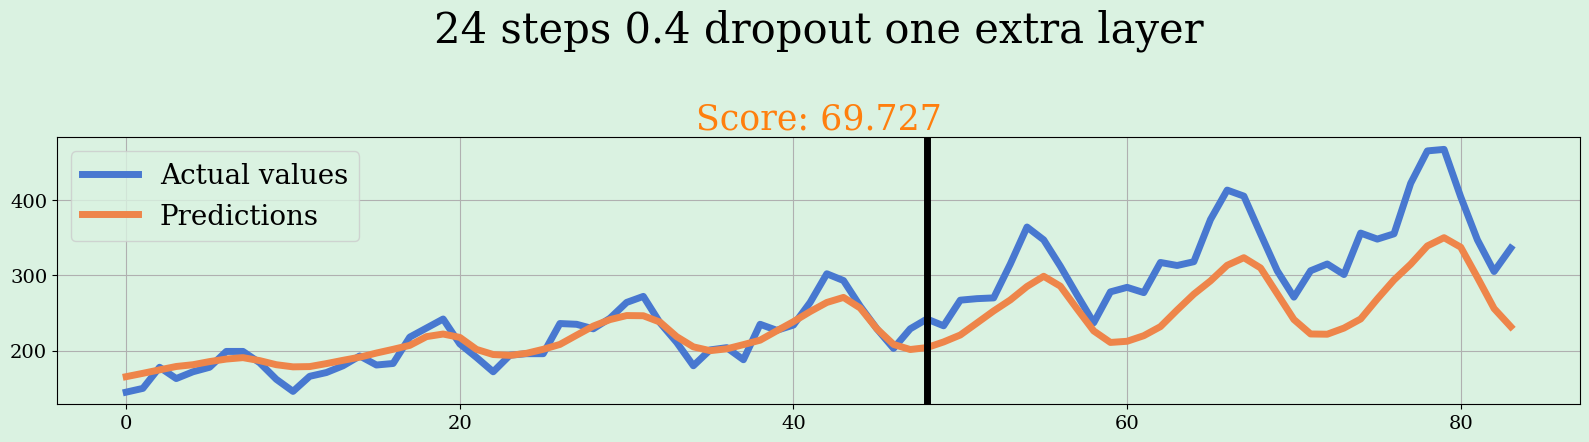

In [45]:
model_name = '24 steps 0.4 dropout one extra layer'
multi_model = Sequential([
    LSTM(600),
    Dropout(0.4),
    Dense(400, activation='relu'),
    Dropout(0.4),
    Dense(200, activation='relu'),
    Dropout(0.4),
    Dense(100, activation='relu'),
    Dropout(0.4),
    Dense(1),
])
history = compile_fit_model(X_train_24, y_train_24, X_val_24, y_val_24,
                            multi_model, callbacks=[early_stopping])
score = evaluate_model(X_train_24, y_train_24, X_val_24, y_val_24,
                       multi_model, history, model_name=model_name)
best_models_score = update_scores(best_models_score, model_name, score)
save_model(multi_model, model_name)

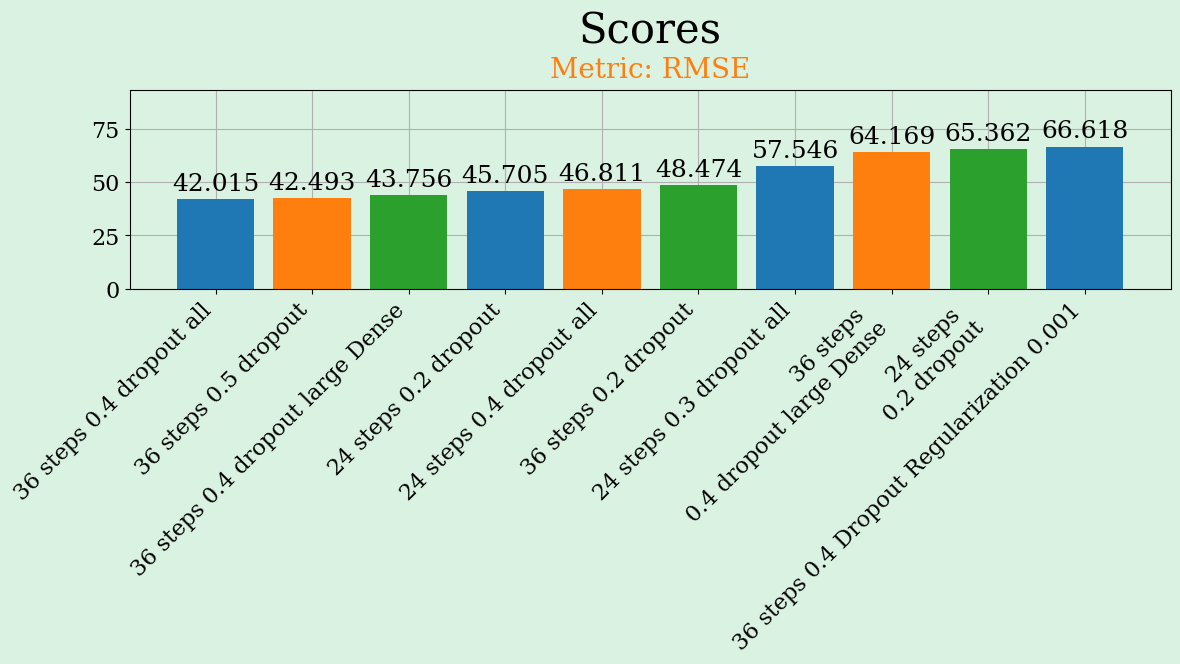

In [82]:
plot_model_results(best_models_score, 'RMSE')

# The same models on the test dataset

In [58]:
train_val_sc = np.concatenate([train_sc, validation_sc])

In [59]:
timesteps = 36
X_train_val_36, y_train_val_36, X_test_36, y_test_36 = \
    create_data(series_sc, train_val_sc, test_sc, timesteps=timesteps)

# 36 Timesteps 0.4 dropout

In [60]:
final_results_score = pd.DataFrame(columns=['ModelName', 'Score'])

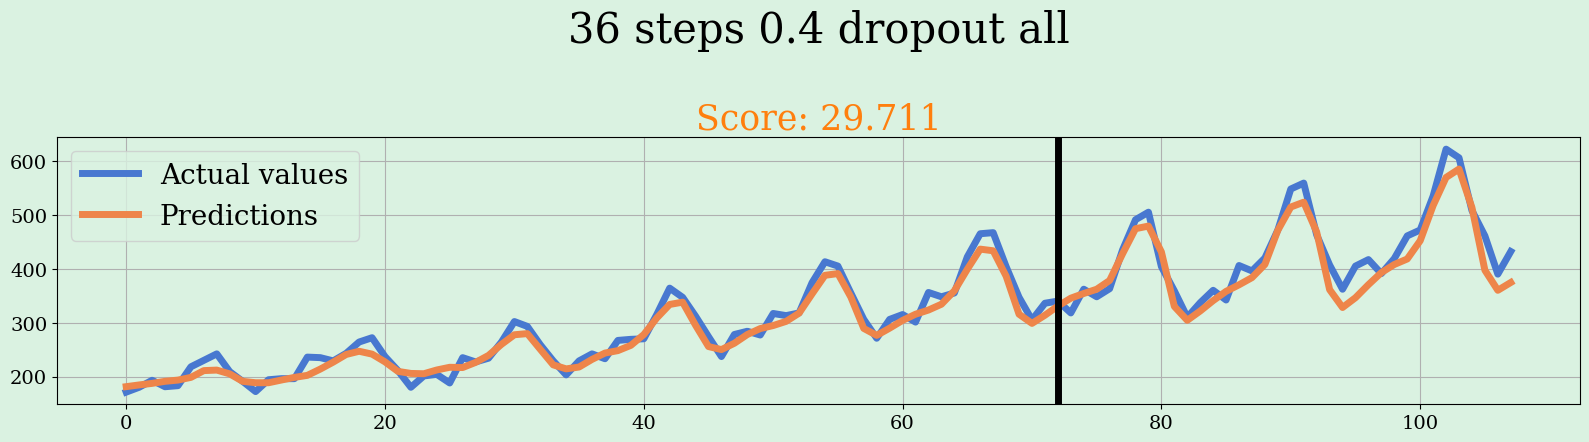

In [62]:
model_name = '36 steps 0.4 dropout'
multi_model = Sequential([
    LSTM(600),
    Dropout(0.4),
    Dense(300, activation='relu'),
    Dropout(0.4),
    Dense(100, activation='relu'),
    Dropout(0.4),
    Dense(1),
])
history = compile_fit_model(X_train_val_36, y_train_val_36, X_test_36, y_test_36,
                            multi_model, callbacks=[early_stopping])
score = evaluate_model(X_train_val_36, y_train_val_36, X_test_36, y_test_36,
                       multi_model, history, model_name=model_name)
final_results_score = update_scores(final_results_score, model_name, score)
save_model(multi_model, model_name)

In [63]:
timesteps = 24
X_train_val_24, y_train_val_24, X_test_24, y_test_24 = \
    create_data(series_sc, train_val_sc, test_sc, timesteps=timesteps)

# 24 Timesteps 0.2 dropout

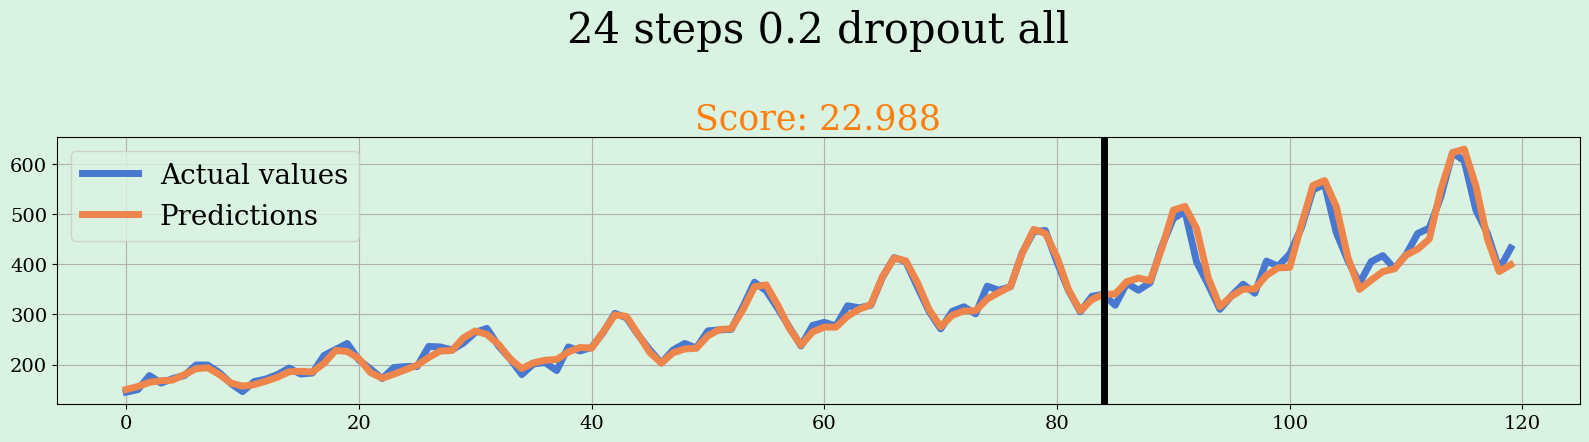

In [64]:
model_name = '24 steps 0.2 dropout'
multi_model = Sequential([
    LSTM(600),
    Dropout(0.2),
    Dense(300, activation='relu'),
    Dropout(0.2),
    Dense(100, activation='relu'),
    Dropout(0.2),
    Dense(1),
])
history = compile_fit_model(X_train_val_24, y_train_val_24, X_test_24, y_test_24,
                            multi_model, callbacks=[early_stopping])
score = evaluate_model(X_train_val_24, y_train_val_24, X_test_24, y_test_24,
                       multi_model, history, model_name=model_name)
final_results_score = update_scores(final_results_score, model_name, score)
save_model(multi_model, model_name)

# Final results

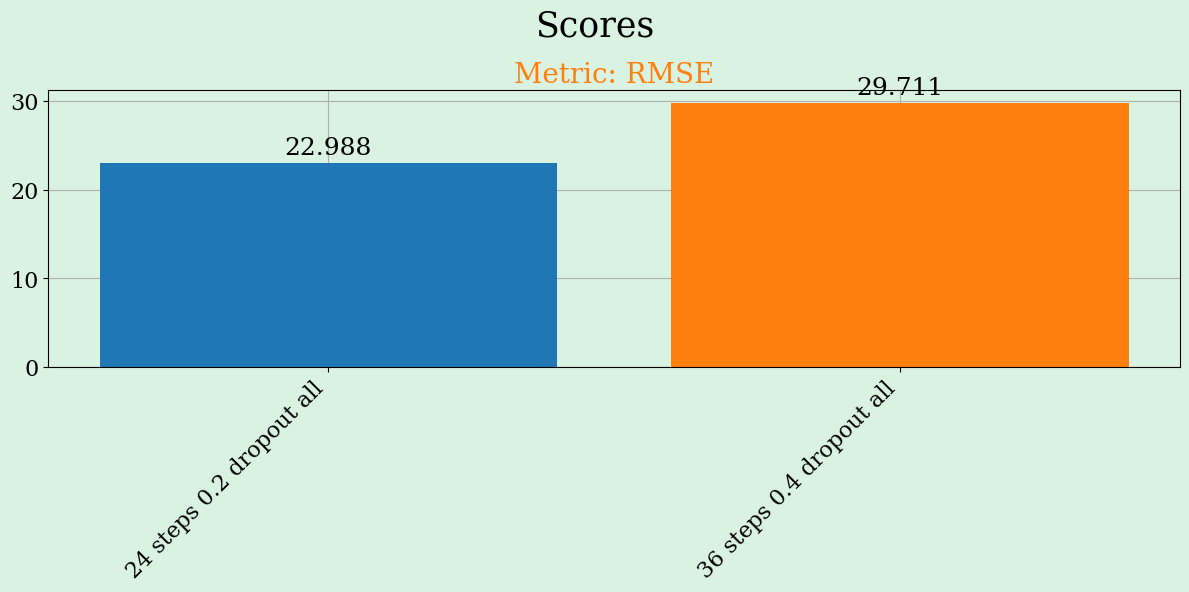

In [66]:
plot_model_results(final_results_score, 'RMSE')